# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os

from numba import njit

In [3]:
# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

## Definitions

In [154]:
# Paths to folders/files
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'
# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [155]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [156]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice



def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    #fam_days = arr_choice[fam_id,:]
    #idx_choice_curr = fam_days[day_curr == fam_days].index
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    #try:
    #    return idx_choice_curr[0]
    #except:
    #    return 10 
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice    

 
def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)

def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def generate_crossing(arr_pop_in):
    '''
    function to generate crossing
    2 parents give 2 children
    Crossing point is randomly chosen
    
    input the current poulation array
    
    return new array of whole population
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    arr_pop = arr_pop_in.copy()
    vect_indiv = np.arange(arr_pop.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    arr_pairs = np.random.choice(vect_indiv, replace=False,
                        size=(int(arr_pop.shape[0]/2), 2))
    
    # loop over pairs of indiv.
    for indice in np.arange(arr_pairs.shape[0]):
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop.shape[1]))
    
        # find parts of second new indiv
        vect_id_1_part_0 = arr_pop[id_1].take(np.arange(fam_id_cross))
        vect_id_1_part_1 = arr_pop[id_0].take(np.arange(fam_id_cross, 
                                                  arr_pop.shape[1])) 
    
        # replace 2 parents by 2 children
        arr_pop[id_0,:] = np.concatenate((vect_id_0_part_0, vect_id_0_part_1))
        arr_pop[id_1,:] = np.concatenate((vect_id_1_part_0, vect_id_1_part_1))
      
    return arr_pop

In [150]:
find_choice_range(6)

range(4, 9)

In [111]:
@njit
def test_min(x):
    x = np.array(x)
    return np.min(x)

test_min([1,2])

1

In [103]:
mutation_day(89, fam_id, 10)

array([68, 42, 81, 24, 24, 19,  7, 42,  2, 19])

In [7]:
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    list_days.append(mutation_day(day_curr, fam_id, 1, True))
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [8]:
nb_mut = 1
vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
t_fit_0 = time.time()
for I in range(0,1000):
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)
    choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'arr_prob' is not defined

In [9]:
choice_new

NameError: name 'choice_new' is not defined

In [10]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'choice_new' is not defined

In [11]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [12]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day_arr(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [13]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_range(choice_curr)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'choice_curr' is not defined

In [14]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [15]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [16]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
        day_new = choose_day_prob(choice_new, fam_id)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)

    
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [17]:

arr_choice = np.array(data_choice)



find_choice_from_day_arr(52, 0)

NameError: name 'data_choice' is not defined

In [18]:
find_choice_from_day(52, 0)

NameError: name 'data_choice' is not defined

In [19]:
def test_fun():
    day_curr = 28
    print(arr_choice[0,:])
    print(arr_choice[0,:] == day_curr)
    idx_choice_curr = np.nonzero(arr_choice[0,:] == day_curr)[0]
    if idx_choice_curr.shape[0] == 0:
        print( 10 )
    else:
        print(idx_choice_curr[0])
test_fun()

NameError: name 'arr_choice' is not defined

In [20]:
arr_prob_fam

NameError: name 'arr_prob_fam' is not defined

In [21]:
arr_choice[fam_id, np.minimum(9, choice_curr)]

NameError: name 'arr_choice' is not defined

In [22]:
data_choice.loc[fam_id, np.minimum(9, choice_curr)]

NameError: name 'data_choice' is not defined

In [23]:
choice_new = np.array([8])

In [24]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob_arr(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'fam_id' is not defined

In [25]:
choose_day_prob_arr(choice_new, fam_id)

NameError: name 'fam_id' is not defined

In [26]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'fam_id' is not defined

In [27]:
choose_day_prob(choice_new, fam_id)

NameError: name 'fam_id' is not defined

In [28]:
day_curr

NameError: name 'day_curr' is not defined

In [29]:
arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum() \
-np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

NameError: name 'arr_prob_fam' is not defined

In [30]:
np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

NameError: name 'df_prob_fam' is not defined

In [31]:
data_choice

NameError: name 'data_choice' is not defined

In [32]:
arr_choice = np.array(data_choice)
arr_choice

NameError: name 'data_choice' is not defined

In [33]:
nb_mut

1

In [34]:
vect_prob

NameError: name 'vect_prob' is not defined

In [35]:
np.array(range_choices)

NameError: name 'range_choices' is not defined

In [36]:
df_prob

NameError: name 'df_prob' is not defined

In [37]:
arr_prob = np.array(df_prob)
arr_prob[0,0]

NameError: name 'df_prob' is not defined

In [38]:
family_size_dict[0]

NameError: name 'family_size_dict' is not defined

In [39]:
arr_prob[family_size_dict[0]-2,range_choices]

NameError: name 'arr_prob' is not defined

In [40]:
data.head()

NameError: name 'data' is not defined

In [41]:
arr_prob_fam = np.array(df_prob_fam.astype("float"))
arr_prob_fam

NameError: name 'df_prob_fam' is not defined

In [578]:
df_prob_fam.head()

1           2           3           4           5    \
family_id                                                                
0          0.000562249  0.00360138  0.00180319  0.00167978  0.00166473   
1          0.000562249  0.00360138  0.00180319   0.0546079    0.053444   
2          0.000565183  0.00362018   0.0018126  0.00168854  0.00167342   
3            0.0516533   0.0556045  0.00182172  0.00169704  0.00168184   
4            0.0534904  0.00360138   0.0517657  0.00167978  0.00166473   

                  6           7           8           9           10   \
family_id                                                               
0           0.0039927  0.00351573  0.00373799  0.00357761   0.0480268   
1           0.0516575  0.00351573  0.00373799  0.00357761  0.00169776   
2          0.00401353  0.00353408  0.00375749  0.00359628   0.0498192   
3           0.0529431  0.00355186   0.0037764    0.049467   0.0017152   
4           0.0039927  0.00351573  0.00373799  0.00357761  0.00169776   

             ...             91         92         93          94   \
family_id    ...                                                     
0            ...      0.00992993  0.0121119   0.013522  0.00232124   
1            ...      0.00992993  0.0121119   0.013522  0.00232124   
2            ...      0.00998174  0.0121751  0.0135926  0.00233335   
3            ...        0.010032  0.0122364   0.013661  0.00234509   
4            ...      0.00992993  0.0121119  0.0653013  0.00232124   

                  95          96         97         98         99         100  
family_id                                                                      
0          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  
1          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  
2          0.00230619  0.00224598  0.0121075  0.0114904  0.0123127    0.06372  
3           0.0536363    0.052695  0.0121684  0.0115482  0.0123747  0.0110066  
4          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  

[5 rows x 100 columns]

## Read in the family information and sample submission

In [8]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


0   1   2   3   4   5   6   7   8   9
family_id                                         
0           52  38  12  82  33  75  64  76  10  28
1           26   4  82   5  11  47  38   6  66  61
2          100  54  25  12  27  82  10  89  80  33
3            2  95   1  96  32   6  40  31   9  59
4           53   1  47  93  26   3  46  16  42  39

In [9]:
data.head()

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    
0                64        76        10        28         4  
1                38         6        66        61         4  
2                10        89        80        33         3  
3                40        31         9        59         2  
4                46        16        42        39         4

In [10]:
submission.head()

assigned_day
family_id              
0                   100
1                    99
2                    98
3                    97
4                    96

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [11]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [12]:
# Build your "cost_function"
cost_function_optim = build_cost_function(data)

In [13]:
#del(cost_function_optim)

In [14]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [15]:
list_p0 = np.array([0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500])
list_pn = np.array([0, 0, 9, 9, 9, 18, 18, 36, 36, 36+199, 36+398])

In [16]:
def cost_function_arr(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        #list_choice = np.array(list_choice)
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        
        if d == choice_0:
            idx_choice = 0
        elif d == choice_1:
            idx_choice = 1
        elif d == choice_2:
            idx_choice = 2
        elif d == choice_3:
            idx_choice = 3
        elif d == choice_4:
            idx_choice = 4
        elif d == choice_5:
            idx_choice = 5
        elif d == choice_6:
            idx_choice = 6
        elif d == choice_7:
            idx_choice = 7
        elif d == choice_8:
            idx_choice = 8
        elif d == choice_9:
            idx_choice = 9
        else:
            idx_choice = 10
        
       # print(idx_choice)
        penalty += list_p0[idx_choice] + n * list_pn[idx_choice]
        

        
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [17]:
cost_function_optim(submission['assigned_day'].values)

10641498.403135022

In [18]:
cost_function_arr(submission['assigned_day'], True)

penalty for only families:  10639591
daily_occupancy:  {100: 206, 99: 203, 98: 209, 97: 204, 96: 233, 95: 203, 94: 210, 93: 197, 92: 207, 91: 237, 90: 211, 89: 220, 88: 212, 87: 204, 86: 203, 85: 211, 84: 214, 83: 209, 82: 211, 81: 232, 80: 204, 79: 226, 78: 217, 77: 211, 76: 208, 75: 199, 74: 213, 73: 203, 72: 223, 71: 218, 70: 210, 69: 207, 68: 197, 67: 189, 66: 203, 65: 204, 64: 219, 63: 222, 62: 205, 61: 227, 60: 211, 59: 195, 58: 215, 57: 198, 56: 201, 55: 210, 54: 213, 53: 213, 52: 199, 51: 212, 50: 214, 49: 199, 48: 205, 47: 207, 46: 226, 45: 203, 44: 224, 43: 208, 42: 209, 41: 220, 40: 201, 39: 214, 38: 207, 37: 196, 36: 212, 35: 203, 34: 204, 33: 199, 32: 233, 31: 225, 30: 211, 29: 206, 28: 228, 27: 201, 26: 217, 25: 207, 24: 209, 23: 198, 22: 214, 21: 209, 20: 216, 19: 201, 18: 188, 17: 212, 16: 200, 15: 206, 14: 210, 13: 205, 12: 192, 11: 216, 10: 237, 9: 207, 8: 214, 7: 207, 6: 198, 5: 221, 4: 217, 3: 206, 2: 230, 1: 203}
accounting_cost:  1907.4031350226594


10641498.403135022

In [24]:
cost_function(df_pop.loc[indice].tolist(), True)

NameError: name 'indice' is not defined

In [72]:
df_cost.sort_values(by="cost").head()

cost
116 -2.150357e+285
185 -2.150357e+285
995 -2.150357e+285
438 -2.150357e+285
460 -2.150357e+285

In [25]:
cost_function_optim(df_pop.loc[116].values)

inc_curr True
inc_curr True
inc_curr True
inc_curr True
inc_curr True
inc_curr True
[ True False  True False False False False False False  True False  True
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
penalty:  600688791.0
accounting_cost:  8394.389326297598


600697185.3893263

In [26]:
cost_function(df_pop.loc[116].values, True)

penalty for only families:  688791
daily_occupancy:  {100: 126, 99: 126, 98: 126, 97: 126, 96: 170, 95: 205, 94: 244, 93: 125, 92: 129, 91: 132, 90: 145, 89: 187, 88: 221, 87: 195, 86: 154, 85: 136, 84: 125, 83: 127, 82: 168, 81: 211, 80: 204, 79: 126, 78: 125, 77: 129, 76: 130, 75: 180, 74: 205, 73: 200, 72: 126, 71: 127, 70: 121, 69: 129, 68: 177, 67: 212, 66: 239, 65: 125, 64: 132, 63: 128, 62: 133, 61: 184, 60: 229, 59: 226, 58: 183, 57: 127, 56: 143, 55: 179, 54: 219, 53: 228, 52: 243, 51: 217, 50: 195, 49: 209, 48: 225, 47: 262, 46: 270, 45: 239, 44: 201, 43: 182, 42: 191, 41: 202, 40: 240, 39: 262, 38: 229, 37: 197, 36: 145, 35: 182, 34: 203, 33: 247, 32: 273, 31: 266, 30: 236, 29: 235, 28: 256, 27: 262, 26: 288, 25: 296, 24: 293, 23: 276, 22: 255, 21: 228, 20: 244, 19: 278, 18: 304, 17: 295, 16: 266, 15: 272, 14: 260, 13: 289, 12: 302, 11: 300, 10: 302, 9: 276, 8: 277, 7: 252, 6: 252, 5: 290, 4: 295, 3: 305, 2: 293, 1: 302}
accounting_cost:  8394.389326297598


600697185.3893263

In [54]:
cost_function_optim(df_pop.loc[indice].tolist())

NameError: name 'df_pop' is not defined

In [57]:
cost_function(submission['assigned_day'].values, True)

penalty for only families:  10639591
daily_occupancy:  {100: 206, 99: 203, 98: 209, 97: 204, 96: 233, 95: 203, 94: 210, 93: 197, 92: 207, 91: 237, 90: 211, 89: 220, 88: 212, 87: 204, 86: 203, 85: 211, 84: 214, 83: 209, 82: 211, 81: 232, 80: 204, 79: 226, 78: 217, 77: 211, 76: 208, 75: 199, 74: 213, 73: 203, 72: 223, 71: 218, 70: 210, 69: 207, 68: 197, 67: 189, 66: 203, 65: 204, 64: 219, 63: 222, 62: 205, 61: 227, 60: 211, 59: 195, 58: 215, 57: 198, 56: 201, 55: 210, 54: 213, 53: 213, 52: 199, 51: 212, 50: 214, 49: 199, 48: 205, 47: 207, 46: 226, 45: 203, 44: 224, 43: 208, 42: 209, 41: 220, 40: 201, 39: 214, 38: 207, 37: 196, 36: 212, 35: 203, 34: 204, 33: 199, 32: 233, 31: 225, 30: 211, 29: 206, 28: 228, 27: 201, 26: 217, 25: 207, 24: 209, 23: 198, 22: 214, 21: 209, 20: 216, 19: 201, 18: 188, 17: 212, 16: 200, 15: 206, 14: 210, 13: 205, 12: 192, 11: 216, 10: 237, 9: 207, 8: 214, 7: 207, 6: 198, 5: 221, 4: 217, 3: 206, 2: 230, 1: 203}
accounting_cost:  1907.4031350226594


10641498.403135022

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
penalty:  10639591.0
accounting_cost:  1907.4031350226594


10641498.403135022

In [776]:
submission['assigned_day'].values

array([100,  99,  98, ...,   3,   2,   1])

In [683]:
for day in submission['assigned_day']:
    arr_fam_cost[n-2, find_choice_from_day_arr(day, 0)]

In [666]:
arr_fam_cost[n-2, find_choice_from_day_arr(51, 0)]

3972

In [781]:
# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
start_score

100001907.40313502

In [771]:
def test_cost_time():
    for I in range(0,1000):
        cost_function(submission['assigned_day'].values)
%time test_cost_time()

CPU times: user 17 ms, sys: 1.12 ms, total: 18.1 ms
Wall time: 19.8 ms


In [765]:
def test_cost_arr_time():
    for I in range(0,1000):
        cost_function_arr(submission['assigned_day'])
%time test_cost_arr_time()

CPU times: user 13 s, sys: 258 ms, total: 13.2 s
Wall time: 15.3 s


In [21]:
def test_cost_optim_time():
    for I in range(0,1000):
        cost_function_optim(submission['assigned_day'].values)
%time test_cost_optim_time()

CPU times: user 35.3 ms, sys: 2.65 ms, total: 37.9 ms
Wall time: 39.6 ms


In [644]:
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

In [652]:
arr_fam_cost = np.array(df_fam_cost.filter(items=[f'choice_{i}' for i in range(11)]))
arr_fam_cost

array([[   0,   50,   68,  118,  218,  236,  336,  372,  472,  970, 1368],
       [   0,   50,   77,  127,  227,  254,  354,  408,  508, 1205, 1802],
       [   0,   50,   86,  136,  236,  272,  372,  444,  544, 1440, 2236],
       [   0,   50,   95,  145,  245,  290,  390,  480,  580, 1675, 2670],
       [   0,   50,  104,  154,  254,  308,  408,  516,  616, 1910, 3104],
       [   0,   50,  113,  163,  263,  326,  426,  552,  652, 2145, 3538],
       [   0,   50,  122,  172,  272,  344,  444,  588,  688, 2380, 3972]])

## Simple Opimization Approach : baseline #0

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [33]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022


KeyboardInterrupt: 

In [172]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [350]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

all_choices  first_choices  mid_choices  last_choices
1        11568           4391         4449          2728
2         1806            501          729           576
3         3607           1021         1526          1060
4         3872           1148         1585          1139
5         3907           1181         1544          1182

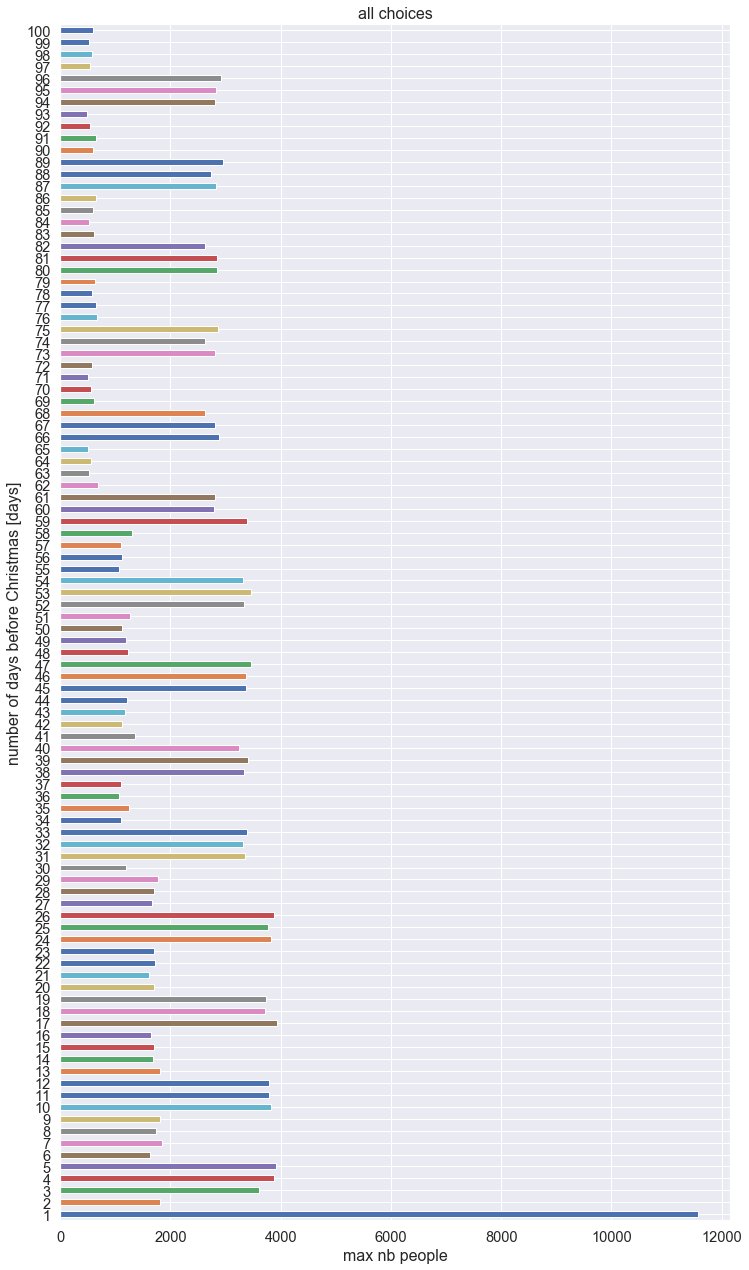

In [351]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

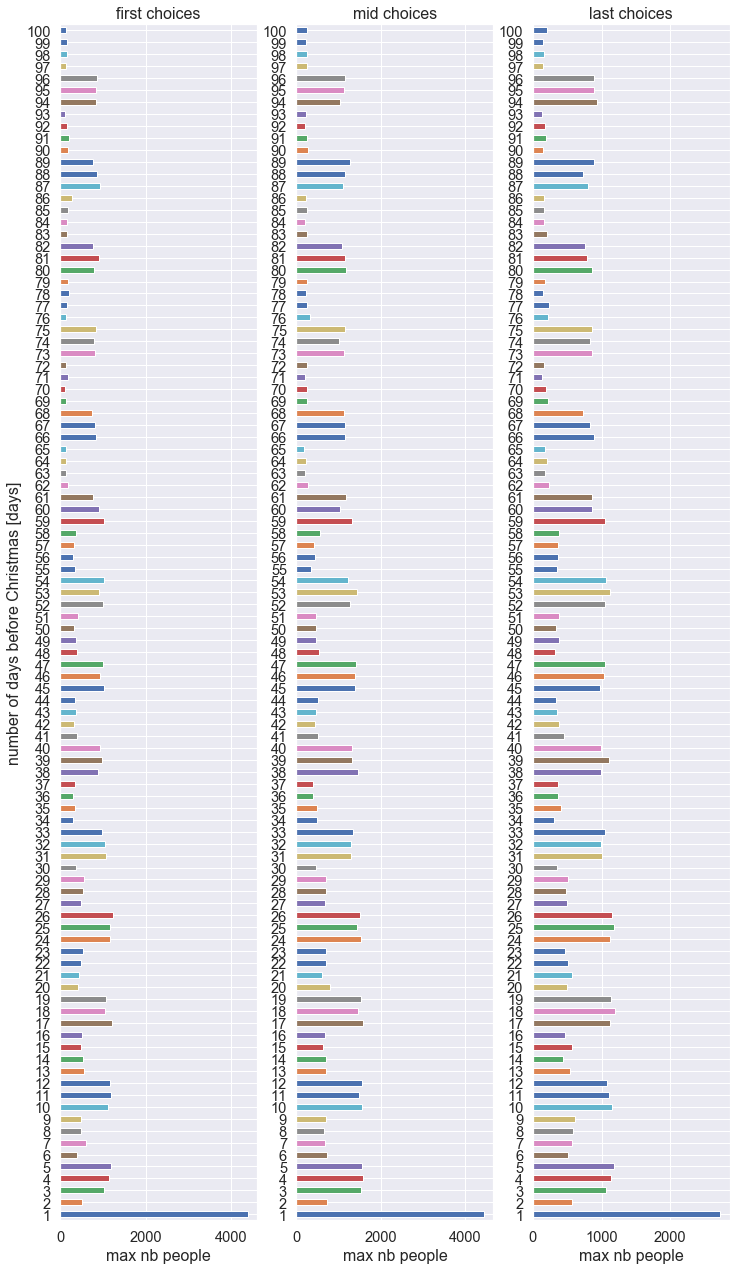

In [352]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [353]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [354]:
df_prob_day.head()

all_choices      prob
1        11568  0.001098
2         1806  0.007036
3         3607  0.003523
4         3872  0.003282
5         3907  0.003252

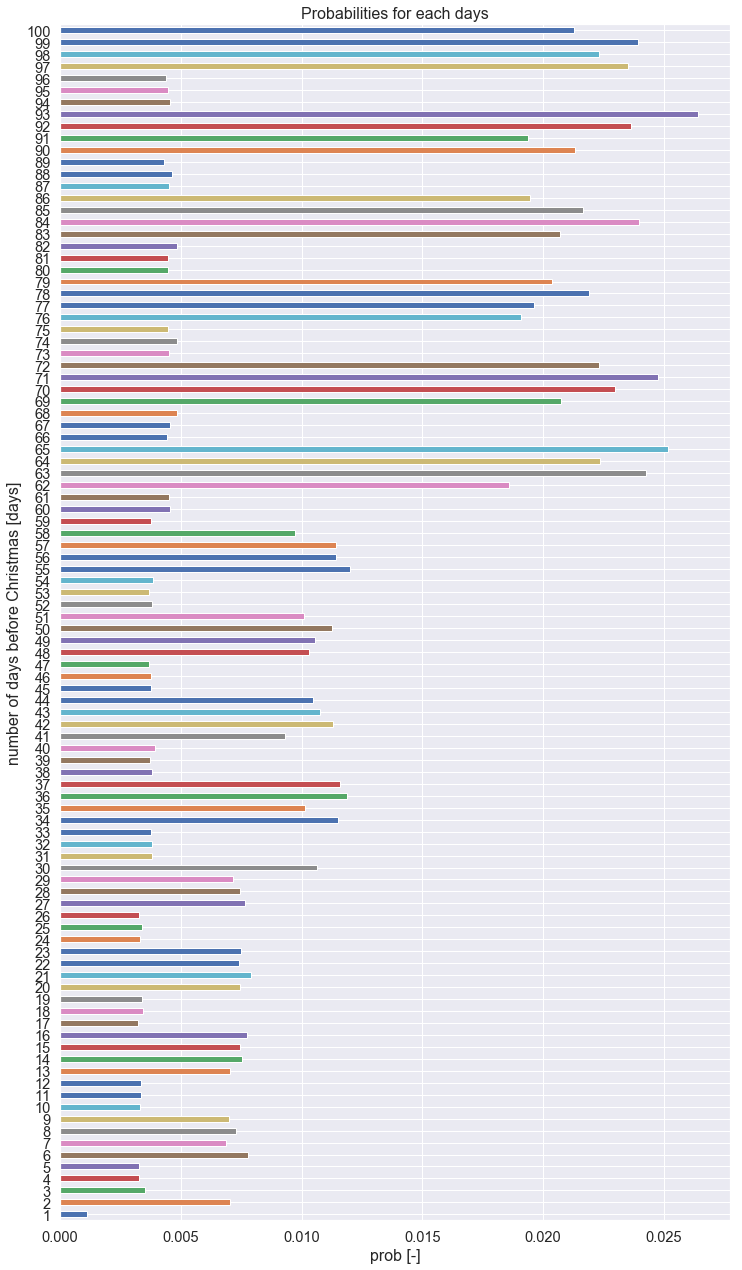

In [355]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [41]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [42]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

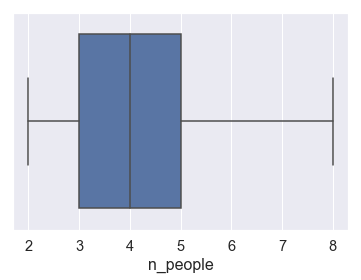

In [43]:
ax = sns.boxplot(x=data["n_people"])


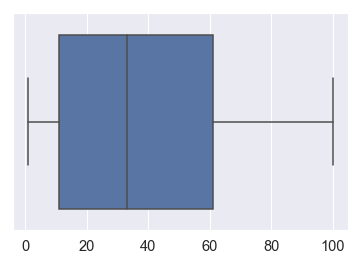

In [44]:
ax = sns.boxplot(data)

In [45]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

choice_0 choice_1 choice_2 choice_3 choice_4 choice_5 choice_6 choice_7  \
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  choice_8 choice_9 choice_10  n  
2      NaN      NaN       NaN  2  
3      NaN      NaN       NaN  3  
4      NaN      NaN       NaN  4  
5      NaN      NaN       NaN  5  
6      NaN      NaN       NaN  6  
7      NaN      NaN       NaN  7  
8      NaN      NaN       NaN  8

In [46]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

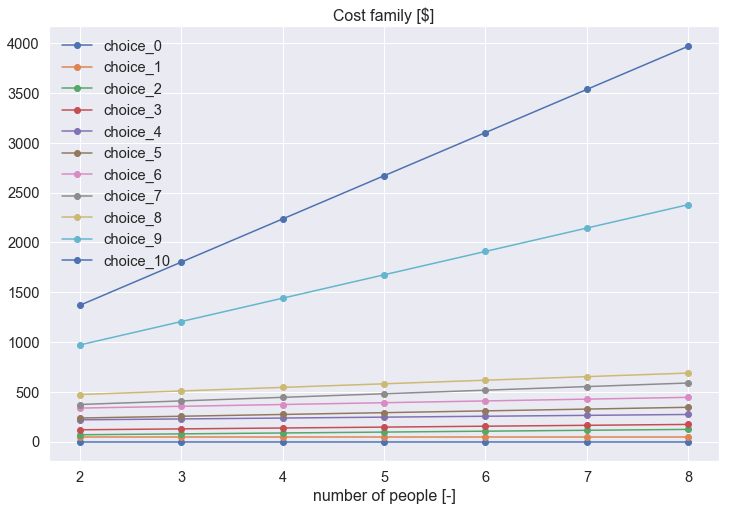

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

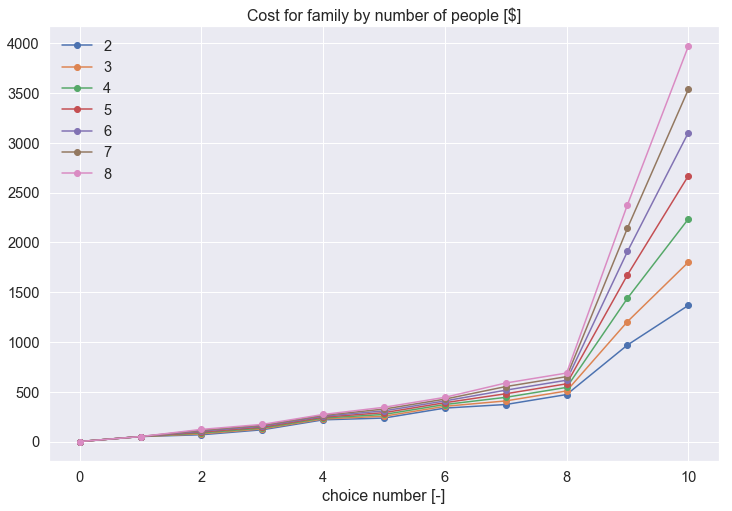

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [346]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

    return df_prob  


#### p max = 0.1, p min = 0.03

In [336]:
df_prob = create_df_fam_cost_prob(df_fam_cost)
df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.097481  0.096622  0.096313  0.095454  0.093736  0.093427  0.091709   
3  0.098846  0.097975  0.097505  0.096634  0.094892  0.094422  0.092680   
4  0.100250  0.099367  0.098731  0.097848  0.096081  0.095445  0.093678   
5  0.101695  0.100799  0.099992  0.099096  0.097304  0.096498  0.094705   
6  0.103182  0.102272  0.101291  0.100381  0.098563  0.097581  0.095763   
7  0.104713  0.103790  0.102627  0.101705  0.099859  0.098697  0.096851   
8  0.106290  0.105353  0.104004  0.103068  0.101195  0.099846  0.097973   

   choice_7  choice_8  choice_9  choice_10  
2  0.091090  0.089372  0.080817   0.073980  
3  0.091739  0.089997  0.077855   0.067455  
4  0.092406  0.090639  0.074809   0.060746  
5  0.093092  0.091300  0.071675   0.053843  
6  0.093799  0.091980  0.068450   0.046738  
7  0.094526  0.092681  0.065129   0.039423  
8  0.095275  0.093402  0.061708   0.031887

#### p max = 0.5, p min = 0.01

In [347]:
df_prob_2 = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob_2

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.100491  0.099238  0.098787  0.097535  0.095030  0.094580  0.092075   
3  0.102556  0.101278  0.100588  0.099310  0.096753  0.096063  0.093507   
4  0.104708  0.103403  0.102463  0.101158  0.098549  0.097609  0.094999   
5  0.106952  0.105619  0.104419  0.103087  0.100421  0.099221  0.096556   
6  0.109294  0.107932  0.106461  0.105099  0.102375  0.100904  0.098180   
7  0.111742  0.110349  0.108594  0.107202  0.104417  0.102662  0.099877   
8  0.114301  0.112877  0.110825  0.109401  0.106552  0.104501  0.101652   

   choice_7  choice_8  choice_9  choice_10  
2  0.091173  0.088669  0.076195   0.066227  
3  0.092127  0.089571  0.071754   0.056494  
4  0.093120  0.090511  0.067127   0.046353  
5  0.094156  0.091491  0.062301   0.035777  
6  0.095238  0.092514  0.057264   0.024738  
7  0.096368  0.093583  0.052001   0.013205  
8  0.097550  0.094701  0.046497   0.001143

In [364]:

# save
joblib.dump(df_prob_2, PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [348]:
def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

In [359]:
df_prob_fam = create_df_prob_day_fam(df_prob_day, df_prob_2)
# save
joblib.dump(df_prob_fam, PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

['../../data/df_prob_fam_2.pkl']

In [358]:

'''df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam'''

'df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)\nfor fam_id in df_prob_fam.index:\n    # give at first to each families the same day probabilities\n    df_prob_fam.loc[fam_id] = df_prob_day["prob"]\n    # and add prob for each day choosen by families\n    for choice in list_choice_all: \n        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]\n        day_curr = data.at[fam_id, choice]\n        # add this prob of these days to family into df_prob_fam\n        df_prob_fam.loc[fam_id, day_curr] += prob_curr\n        #print(day_curr)\n        #print(prob_curr)\n    df_prob_fam.loc[fam_id] =         df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()\n    \n     \n    \ndf_prob_fam'

In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

In [322]:
df_prob_fam.loc[0].plot()

NameError: name 'df_prob_fam' is not defined

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     3     3     5     8     3     9     4     1     2     6  ...      0   
1     7     3     0     6     0     9     9     4     8     7  ...      2   
2     1     4     1    10     4     1     5     7     5     5  ...      0   
3     4     9     6     0     6     6     2     5     5     1  ...      7   
4     8     7     7     5     3     4     5     2     8     3  ...      5   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     4     7     2     0     9     1     1     8     6  
1     3     3     3     5     1     1     9     2     3  
2     4     6     6     7     0     8     4     8     5  
3     7     8     4     2     6    10     2     2     4  
4     8     8     0     6     7     1     1     8    10  

[5 rows x 5000 columns]

### Treatment of choices

In [301]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0      82     5    82     9    93     2    91    11     1    96  ...     47   
1      76     5   100    40    53     2    99    10    53    47  ...     74   
2      38    11    54    54    26    59    32    50    33    18  ...     47   
3      33    61    10     2    46    35     1    17    33    88  ...     94   
4      10     6    89     6    93    60    32    52    53    50  ...     46   
5      52     5    27    96    39    26    57    88     1    39  ...      5   
6      38    40    27    59     1    32    99    11     1    28  ...     61   
7      33    97    25    93     3    59    88    17    33    96  ...     74   
8      75    11    80     6    46    78     4    88    18    39  ...      4   
9      52    11    25    32    93    12    57    48    12    18  ...     32   
10     82    11    10     2     1    50    99    66    89    39  ...     80   
11     12     4    27    95    84    60    99    17     1    88  ...     12   
12     38    49    80    31    26     2    91    17    10    18  ...     19   
13     82    55    33    95     1    12    91    66    16    18  ...     46   
14     12     4    89     9    53    60    91    17    12    28  ...      4   
15     38    26    82     9    90    32     1    10    39     1  ...     19   
16     12    82    82    40    47     2     3    66    60    28  ...     19   
17     12    26   100    31     3    60     4    25     1    46  ...      4   
18     10    66    10    59    53    60    99    50    33     1  ...     74   
19     28    66     9    59    26     2    39    10    10    26  ...     80   
20     64    66    54     9    39    26    28    10    10    46  ...     80   
21     76    38    80    31    46     5    88    11    89    18  ...     74   
22     82    66    33    40    93     2     3    17    16    39  ...     61   
23     33     4    29     2    90    32    57    32    10    28  ...     47   
24     12    47    10     9     3    12     3    88    18    26  ...     33   
25     76    29    25     9    53    59     3    10    33    88  ...     32   
26     52    61    33     6    47    26    91    88    60    47  ...     12   
27     64     4    33    40     1    26    26    50    67    39  ...     12   
28     76    47    82    31    53     2    39    11     1    19  ...     32   
29     76     4    80     2    39    60     1    50    16    88  ...     94   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
970    12    38    10    32     1    32     1    88    33    18  ...     80   
971    10    11    66    95    93    50    32    25    18    39  ...     12   
972    12    38    82     2    39    59    99    11    33    28  ...     47   
973    12    47    33    31    39    26    99    66    12    39  ...     80   
974    39    26    27     2     3     3    28    20    60    26  ...      4   
975    10     6    25    96     1    18    39    95    33    18  ...     32   
976    28    47    80    25    16    35     4    25    89    96  ...     19   
977    75    11    25    31    26    50    39    10    12    39  ...     74   
978    10    82    82    40    26     3     3    52    33    73  ...     32   
979    28     5    25    59    39     5     4    66    60    46  ...     47   
980    12    66   100    32    46    60     1    11    12    47  ...     80   
981    28    26    27    31    93    35     3    10    18    26  ...     47   
982    33    61   100     4    93    26    88    88    33    88  ...     80   
983    33     6    27     6     3    35    39    95    53    28  ...     47   
984    10    61    54    31    16    12    28    25    33    39  ...     19   
985    75    66   100    44    26     5    57    50    18    28  ...     47   
986    10     4    10     2     3    32     4    50    12    96  ...     46   
987    52     6    33    59    39    60    39    10     1    88  ...     32   
988    38    82    12    59    93    35    28    11    

### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    4.405331e+62
1    8.627548e+56
2    1.346244e+59
3    5.624646e+61
4    7.746507e+61
5    2.343082e+51
6    4.598295e+66
7    7.982710e+56
8    1.347359e+57
9    1.105799e+60
10   3.893130e+59
11   3.936574e+58
12   1.621637e+63
13   8.510317e+52
14   5.895593e+59
15   3.340682e+55
16   1.358198e+57
17   1.079468e+64
18   5.832608e+60
19   4.579328e+60
20   7.319800e+50
21   5.446452e+56
22   2.165810e+54
23   9.561077e+62
24   8.721047e+45
25   2.068069e+60
26   2.355648e+53
27   1.844667e+70
28   7.279254e+61
29   2.525690e+60
..            ...
970  2.353798e+53
971  1.748307e+63
972  6.841872e+70
973  1.497576e+52
974  4.638929e+67
975  1.978431e+53
976  1.781199e+60
977  1.518226e+59
978  1.235310e+60
979  4.351479e+56
980  1.345891e+54
981  2.343632e+57
982  2.683243e+62
983  6.366676e+52
984  3.907275e+53
985  5.390364e+70
986  1.374826e+58
987  1.280499e+55
988  8.832879e+63
989  8.525397e+64
990  5.807663e+56
991  1.103143e+55
992  7.475599e+53
993  9.080145e+57
994  7.006668e+57
995  4.932254e+65
996  5.323330e+49
997  2.865219e+55
998  3.724813e+63
999  1.000177e+55

[1000 rows x 1 columns]

In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

## From baseline #0

In [173]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [558]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 "families choices" ensemble from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [654]:
# check baseline
cost_function(submission['assigned_day'])

10641498.403135022

In [81]:


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [ ]:
df_pop = generate_pop()
print("df_pop.shape: ", df_pop.shape)
df_pop.head()

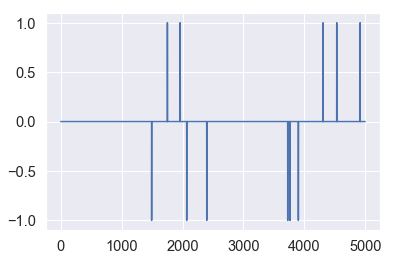

In [571]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

A effacer : 

In [83]:
# GENERATION OF FIRST POP:

# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

# create NB_FIRST_POP family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

### Save pop

In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

### Evaluation #1

In [570]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [544]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    672254.027668
21   673249.435665
632  675341.022931
587  675579.598524
904  675800.361230
552  676043.157413
148  676060.161931
215  676639.495767
599  676960.819718
550  677205.766828

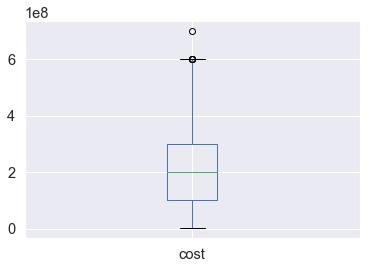

In [545]:
df_cost.boxplot()

### Loop over generations

In [546]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

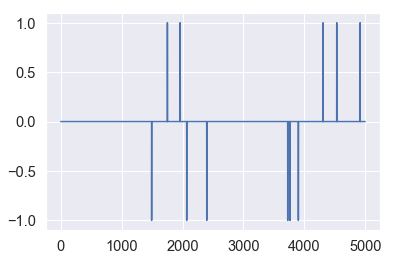

In [547]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
990  672254.027668
991  673249.435665
21   675086.477112
238  675663.626834
743  675797.897188
Timing epoch:  13.22744607925415
 
GENERATION #1 / nb. pop: 992
nb_survivor:  982
              cost
982  672254.027668
983  673249.435665
302  675468.568847
303  675777.101886
561  676477.414141
Timing epoch:  13.66027307510376
 
GENERATION #2 / nb. pop: 984
nb_survivor:  974
              cost
0    672254.027668
974  672254.027668
975  673249.435665
805  674974.609299
845  675310.694047
Timing epoch:  12.444685935974121


Text(0, 0.5, 'cost [$]')

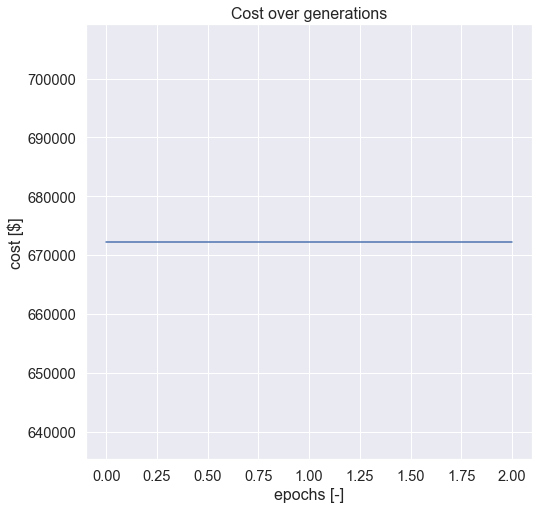

In [548]:
nb_seeds = 2 # number of seed sources : keep them along epochs
# LOOP OVER GENERATIONS 
list_best_cost = []
for gen_id in range(0, NB_MAX_EPOCHS):
    t_fit_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]
    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - nb_seeds)
    if (nb_survivor+nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))
    
    # check if previous best is still here
    #if name_best not in vect_survivor:
        # else replace by previous best
        #vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    #df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    #df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(df_best, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(nb_seeds+3))
    
    t_fit_1 = time.time()
    print("Timing epoch: ", t_fit_1 - t_fit_0)
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

cost rankings:
[672254.0276683343, 673249.4356646903, 674728.7104080453, 675890.9699308008, 675979.8116211004]


In [518]:
list_name_best

[983, 314]

In [519]:
df_pop.loc[list_name_best]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


family_id  0     1      2     3     4     5     6     7     8     9     ...   \
983         NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
314        52.0  26.0  100.0   2.0  53.0  59.0  88.0  25.0  18.0   1.0  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
983         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
314        61.0  29.0  90.0  62.0  52.0  16.0  88.0  32.0  67.0  13.0  

[2 rows x 5000 columns]

In [510]:

np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), vect_survivor))

array([990, 803, 867, 174, 379, 990, 193, 507, 142, 785, 631, 533, 422,
       203, 580, 977, 387,  20, 393, 612, 803, 505, 811, 359,  46, 461,
       944, 169, 775, 897, 467, 648, 976, 376, 518, 114, 741, 108, 181,
       768, 745, 330, 750, 705,  25, 163, 406, 736, 924,   5, 761,  40,
       430, 723, 876,  52, 879, 102, 820, 899, 516, 374, 337, 249, 302,
       559, 950, 759, 217, 920, 546, 550, 482,  35,  66, 277, 686, 492,
       601, 248, 267, 195, 522, 791,   1, 228, 534, 287, 969, 242, 814,
       988, 746, 835, 531, 166, 312, 110, 839,  50, 951,  80, 925, 341,
       189, 140, 433, 513, 933, 152, 680, 959, 927,  94, 921, 500, 470,
       582,  18, 887, 480, 639, 429,  79, 399, 397, 269,  51, 216, 424,
       415, 188, 731, 451, 810, 818, 272, 136, 663, 562, 457, 443,  15,
       673, 545, 871, 548, 788, 782, 172, 633, 848,  92, 535, 958, 437,
       726, 836, 564, 787, 598, 986, 698,  83,  95, 843, 261, 150, 450,
         7, 180, 348, 754, 692, 834, 520, 645, 144, 230, 640, 22

In [492]:
df_cost_sort.shape

(991, 3)

In [499]:
df_cost_sort.iloc[0:2,2] = 0

In [500]:
df_cost_sort

cost  rank      prob
990  6.722540e+05     1  0.000000
803  6.740412e+05     2  0.000000
723  6.743262e+05     3  0.044585
976  6.752261e+05     4  0.033438
5    6.753410e+05     5  0.026751
871  6.757341e+05     6  0.022292
25   6.760432e+05     7  0.019108
768  6.766036e+05     8  0.016719
169  6.766395e+05     9  0.014862
46   6.769514e+05    10  0.013375
461  6.770891e+05    11  0.012159
20   6.776100e+05    12  0.011146
920  6.779448e+05    13  0.010289
397  6.782558e+05    14  0.009554
761  6.782579e+05    15  0.008917
470  6.782830e+05    16  0.008360
376  6.783910e+05    17  0.007868
522  6.783969e+05    18  0.007431
580  6.786026e+05    19  0.007040
114  6.787559e+05    20  0.006688
40   6.792164e+05    21  0.006369
925  6.794635e+05    22  0.006080
242  6.795082e+05    23  0.005815
759  6.797625e+05    24  0.005573
141  6.800638e+05    25  0.005350
516  6.801533e+05    26  0.005144
142  6.804211e+05    27  0.004954
550  6.806977e+05    28  0.004777
387  6.807988e+05    29  0.004612
986  6.809628e+05    30  0.004458
..            ...   ...       ...
914  5.007527e+08   962  0.000139
256  5.007535e+08   963  0.000139
949  5.007557e+08   964  0.000139
781  5.007564e+08   965  0.000139
207  5.007603e+08   966  0.000138
629  5.007668e+08   967  0.000138
335  5.007700e+08   968  0.000138
24   5.007761e+08   969  0.000138
816  6.006767e+08   970  0.000138
953  6.006855e+08   971  0.000138
904  6.006864e+08   972  0.000138
638  6.006886e+08   973  0.000137
143  6.006930e+08   974  0.000137
872  6.006934e+08   975  0.000137
933  6.006985e+08   976  0.000137
873  6.006998e+08   977  0.000137
830  6.007444e+08   978  0.000137
84   6.007514e+08   979  0.000137
547  6.007529e+08   980  0.000136
259  6.007560e+08   981  0.000136
586  6.007606e+08   982  0.000136
911  6.007691e+08   983  0.000136
235  6.008261e+08   984  0.000136
795  7.006870e+08   985  0.000136
491  7.007442e+08   986  0.000136
678  7.007611e+08   987  0.000136
201  7.007786e+08   988  0.000135
910  8.007432e+08   989  0.000135
942  8.007518e+08   990  0.000135
436  1.000755e+09   991  0.000135

[991 rows x 3 columns]

In [480]:
df_cost_sort.shape

(991, 3)

In [477]:
list_best_indiv[1]

family_id
0        52
1        26
2       100
3         2
4        53
5        59
6        88
7        25
8        18
9         1
10       92
11       19
12       52
13       54
14       45
15       22
16       46
17       47
18       75
19        3
20        3
21       56
22       33
23       19
24       75
25       16
26       58
27       38
28       27
29       89
       ... 
4970     22
4971      8
4972      8
4973      5
4974     15
4975     83
4976     39
4977     54
4978     40
4979     55
4980     28
4981     44
4982     47
4983     16
4984     41
4985     25
4986     82
4987     22
4988     88
4989     92
4990     61
4991     29
4992     90
4993     62
4994     52
4995     16
4996     88
4997     32
4998     67
4999     13
Name: 803, Length: 5000, dtype: int64

In [451]:
df_cost_sort.head()

cost  rank      prob
198  6.696340e+05     1  0.170270
77   3.010847e+08     2  0.085135
19   4.009763e+08     3  0.056757
64   4.012742e+08     4  0.042567
52   5.007436e+08     5  0.034054

In [296]:
cost_function(df_pop.loc[0].tolist())

672254.0276683343

In [308]:
cost_function(best_indiv)

669634.0092723282

In [304]:
vect_best_choice=[]
for fam_id in df_pop.columns:
    vect_best_choice.append(choose_day(0,fam_id))

In [307]:
len(vect_best_choice)

5000

In [309]:
cost_function(vect_best_choice)

1.0647073818721987e+90

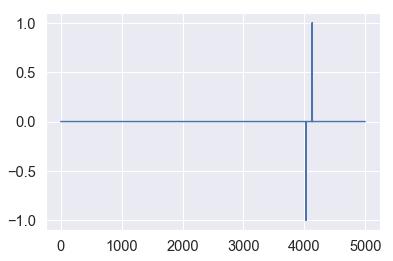

In [298]:
plt.plot(df_pop.columns, df_pop.loc[0] - best_indiv)
   

283


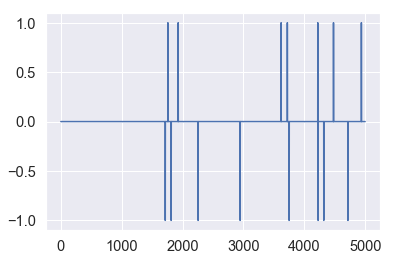

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

283


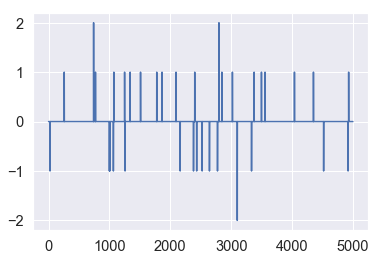

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

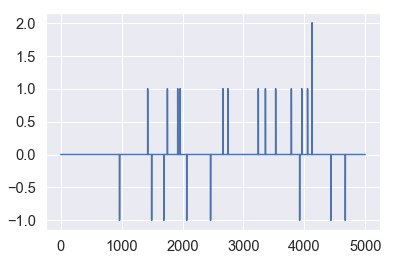

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

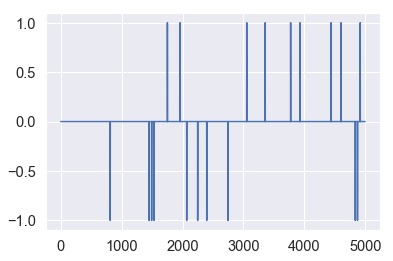

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [52]:
submission = pd.read_csv(fpath, index_col='family_id')

In [53]:
submission.shape[0]

5000

In [54]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

#for indice in range(2, NB_FIRST_SEED):
    

In [55]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [56]:
np.array(range(10,0,-1))

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [57]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [24]:
df_range.min().min()

0

In [25]:
df_range.max().max()

4999

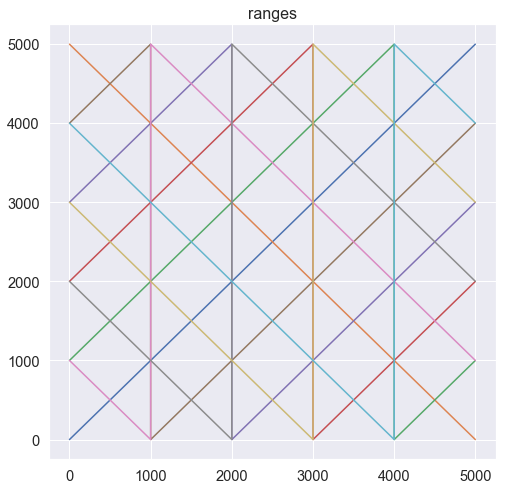

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [449]:
t_fit_0 = time.time()
submission = pd.read_csv(fpath, index_col='family_id')
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 657505.9426095837
Score: 677348.7683962411
Score: 605419.8337085167
Score: 656228.7546566363
Timing:  1473.9507336616516


### Generate first population

#### Method 1:  Day by days

In [27]:
df_range

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [88]:
# HYPERPARAMETERS
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop(seed_indiv=seed_indiv, nb_pop=nb_indiv_curr, 
                               r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  91.89893078804016
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  84.70671820640564
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  85.22644996643066
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  694.5717761516571
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  111.29203581809998
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  82.3056640625
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation populati

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     2  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

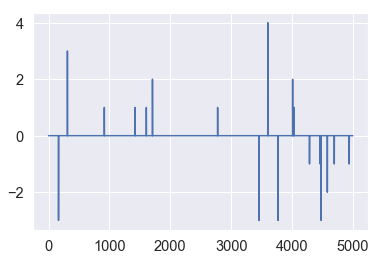

In [90]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [91]:
df_pop.describe()

family_id         0            1            2            3            4     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         56.001000    52.999000    99.998000    30.492000    52.994000   
std          22.875102    38.102583     0.063246    43.550713     0.141365   
min          38.000000     4.000000    98.000000     1.000000    50.000000   
25%          38.000000    26.000000   100.000000     2.000000    53.000000   
50%          52.000000    26.000000   100.000000     2.000000    53.000000   
75%          52.000000    99.000000   100.000000    97.000000    53.000000   
max         100.000000   100.000000   100.000000    97.000000    54.000000   

family_id         5            6            7            8            9     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         42.814000    71.211000    59.097000    22.196000    52.184000   
std          13.234748    33.633133    29.094434    12.608273    30.926471   
min          29.000000     1.000000    22.000000    16.000000     1.000000   
25%          32.000000    88.000000    25.000000    18.000000    50.000000   
50%          32.000000    88.000000    48.000000    18.000000    50.000000   
75%          59.000000    88.000000    93.000000    18.000000    88.000000   
max          62.000000    91.000000    95.000000    60.000000    91.000000   

family_id     ...             4990         4991        4992         4993  \
count         ...      1000.000000  1000.000000  1000.00000  1000.000000   
mean          ...        56.706000    43.411000    27.59700    62.003000   
std           ...         8.773742     4.811989    31.21979     0.170353   
min           ...        47.000000    28.000000     9.00000    60.000000   
25%           ...        47.000000    45.000000    12.00000    62.000000   
50%           ...        61.000000    45.000000    12.00000    62.000000   
75%           ...        61.000000    45.000000    12.00000    62.000000   
max           ...        77.000000    47.000000    91.00000    65.000000   

family_id         4994         4995         4996        4997         4998  \
count      1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean         53.405000    16.010000    67.609000    38.80100    79.506000   
std           2.797642     0.141138    31.183369    13.60016    12.502811   
min          51.000000    16.000000    20.000000    29.00000    67.000000   
25%          52.000000    16.000000    20.000000    32.00000    67.000000   
50%          52.000000    16.000000    88.000000    32.00000    81.000000   
75%          52.000000    16.000000    88.000000    32.00000    92.000000   
max          59.000000    18.000000    91.000000    66.00000    93.000000   

family_id        4999  
count      1000.00000  
mean         14.19500  
std           3.60527  
min          11.00000  
25%          13.00000  
50%          13.00000  
75%          13.00000  
max          25.00000  

[8 rows x 5000 columns]

#### Method 2:  Choice by Choices

In [432]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [433]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

#df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  53.41584396362305
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.22392964363098
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  44.29747796058655
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.89790415763855
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  45.88465929031372
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  47.983644247055054
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation popu

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32     4    13  

[5 rows x 5000 columns]

#### Save pop

In [435]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE),
           compress=True)

['../../data/df_pop_choices1000_fs10_rfm0.01_dc1.pkl']

## Run with pop by choices

### Evaluation #1

In [157]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

In [158]:
NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))

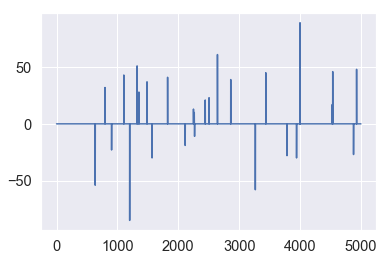

In [159]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [160]:
# create cost dataFrame for all population
t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print(time.time()-t_1)

df_cost.sort_values(by="cost").head(10)


0.8920938968658447


cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
0    672254.027668
700  677348.768396
300  679410.167648
200  684479.327148
500  686524.150792
342  689530.226809

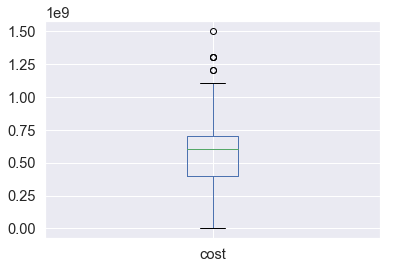

In [161]:
df_cost.boxplot()

###  Loop over generations

GEN. #0 / cost: [574749.4411283] / nb. pop: 100 / timing: 0.12237215042114258
GEN. #10 / cost: [574671.38524566] / nb. pop: 100 / timing: 0.09777212142944336
GEN. #20 / cost: [574671.38524566] / nb. pop: 100 / timing: 0.09994101524353027
GEN. #30 / cost: [574618.51842973] / nb. pop: 100 / timing: 0.08293294906616211
GEN. #40 / cost: [574618.51842973] / nb. pop: 100 / timing: 0.11789417266845703
GEN. #50 / cost: [574438.00079741] / nb. pop: 100 / timing: 0.17574095726013184
GEN. #60 / cost: [574438.00079741] / nb. pop: 100 / timing: 0.11296796798706055
GEN. #70 / cost: [574419.27973829] / nb. pop: 100 / timing: 0.162369966506958
GEN. #80 / cost: [574351.27031706] / nb. pop: 100 / timing: 0.10453081130981445
GEN. #90 / cost: [574351.27031706] / nb. pop: 100 / timing: 0.10320806503295898
END:
LAST GEN. #99 / cost: [574351.27031706] / nb. pop: 100 / timing Total: 10.210494995117188


Text(0, 0.5, 'cost [$]')

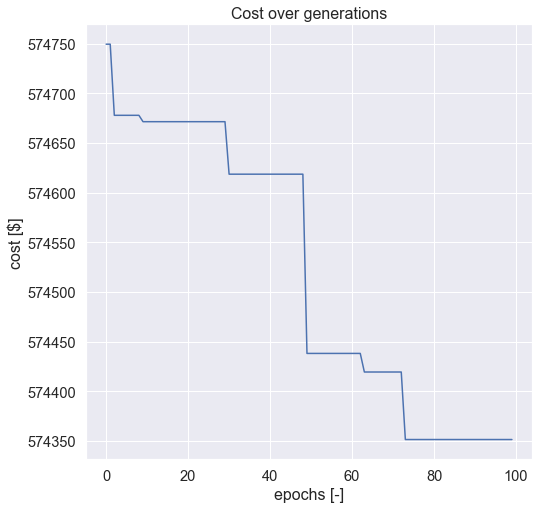

In [167]:
# HYPER-PARAMETES
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 100000
R_POP_LOST = 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2

# DISPLAY PARAM
flag_prompt = False
prompt_freq = 1000

# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    
    t_epoch_0 = time.time()
    if flag_prompt:
        t_lost_0 = time.time()

    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 
    
    if flag_prompt:
        t_lost_1 = time.time()
        print("Timing lost: ", t_lost_1 - t_lost_0)
    if flag_prompt:
        t_cross_0 = time.time()
    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    
    arr_pop = np.array(df_pop) # df_pop = f(indiv., families)
    
    arr_pop = generate_crossing(arr_pop)
    
    if flag_prompt:
        t_cross_1 = time.time()
        print("Timing cross: ", t_cross_1 - t_cross_0)
    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    if flag_prompt:
        t_mut_0 = time.time()
    nb_mut = int(R_POP_MUT*arr_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(range(0, arr_pop.shape[0]), size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*arr_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(range(0, arr_pop.shape[1]), size=nb_fam_mut)
        for fam_id in fam_mut:
            arr_pop[indice, fam_id] = \
                mutation_day(arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    arr_pop = np.append(arr_pop, np.array(df_best), axis=0)
    df_pop = pd.DataFrame(data=arr_pop)
    #df_pop = df_pop.append(df_best, ignore_index=True)
    if flag_prompt:
        t_mut_1 = time.time()
        print("Timing mutation: ", t_mut_1 - t_mut_0)
    ############
    # EVALUATION
    # create cost dataFrame for all population
    if flag_prompt:
        t_eval_0 = time.time()
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(arr_pop[indice,:])

    if flag_prompt:
        t_eval_1 = time.time()
        print("Timing eval: ", t_eval_1 - t_eval_0)
    
    t_epoch_1 = time.time()
    if (flag_prompt) | (gen_id % prompt_freq == 0):
        print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))

#timing 
t_fit_1 = time.time()
print("END:")
print("LAST GEN. #{} / cost: {} / nb. pop: {} / timing Total: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_fit_1 - t_fit_0)) 
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

In [88]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[266433.55706385]


#### Save results

In [89]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_gen50000_s266433.pkl']

 
GENERATION #0 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.4269251823425293
 
GENERATION #1 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.382321834564209
 
GENERATION #2 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.7789270877838135
 
GENERATION #3 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.44901609420776367
 
GENERATION #4 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.35001182556152344
 
GENERATION #5 / nb. pop: 32
nb_survivor:  32
             cost
11  565385.075003
Timing epoch:  0.3471691608428955
 
GENERATION #6 / nb. pop: 32
nb_survivor:  32
             cost
22  565385.075003
Timing epoch:  0.3910977840423584
 
GENERATION #7 / nb. pop: 32
nb_survivor:  32
             cost
22  565385.075003
Timing epoch:  0.3407909870147705
 
GENERATION #8 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Ti

            cost
0  565385.075003
Timing epoch:  0.32091403007507324
 
GENERATION #72 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3380460739135742
 
GENERATION #73 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.32477712631225586
 
GENERATION #74 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3173801898956299
 
GENERATION #75 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.32683897018432617
 
GENERATION #76 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.33784914016723633
 
GENERATION #77 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3197011947631836
 
GENERATION #78 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3211939334869385
 
GENERATION #79 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3517839908599

            cost
0  565385.075003
Timing epoch:  0.5474598407745361
 
GENERATION #142 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3529469966888428
 
GENERATION #143 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.42020297050476074
 
GENERATION #144 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3571147918701172
 
GENERATION #145 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.4325289726257324
 
GENERATION #146 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3488337993621826
 
GENERATION #147 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.4183380603790283
 
GENERATION #148 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3636322021484375
 
GENERATION #149 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.340821

            cost
8  565354.043958
Timing epoch:  0.31541919708251953
 
GENERATION #212 / nb. pop: 32
nb_survivor:  32
            cost
5  565354.043958
Timing epoch:  0.3204221725463867
 
GENERATION #213 / nb. pop: 32
nb_survivor:  32
            cost
2  565354.043958
Timing epoch:  0.34300994873046875
 
GENERATION #214 / nb. pop: 32
nb_survivor:  32
             cost
25  565354.043958
Timing epoch:  0.3127632141113281
 
GENERATION #215 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.32523083686828613
 
GENERATION #216 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.35355687141418457
 
GENERATION #217 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3135948181152344
 
GENERATION #218 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3271462917327881
 
GENERATION #219 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3522639

            cost
0  565354.043958
Timing epoch:  0.3246636390686035
 
GENERATION #282 / nb. pop: 32
nb_survivor:  32
             cost
15  565354.043958
Timing epoch:  0.3204622268676758
 
GENERATION #283 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3638889789581299
 
GENERATION #284 / nb. pop: 32
nb_survivor:  32
             cost
31  565354.043958
Timing epoch:  0.3120241165161133
 
GENERATION #285 / nb. pop: 32
nb_survivor:  32
             cost
31  565354.043958
Timing epoch:  0.3139157295227051
 
GENERATION #286 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.331157922744751
 
GENERATION #287 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.31656599044799805
 
GENERATION #288 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.31182003021240234
 
GENERATION #289 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.338935

            cost
0  565312.205743
Timing epoch:  0.32041311264038086
 
GENERATION #352 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32414698600769043
 
GENERATION #353 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32848119735717773
 
GENERATION #354 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31360816955566406
 
GENERATION #355 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.32509303092956543
 
GENERATION #356 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.37078404426574707
 
GENERATION #357 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31726813316345215
 
GENERATION #358 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3183557987213135
 
GENERATION #359 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.35

            cost
0  565312.205743
Timing epoch:  0.31630492210388184
 
GENERATION #422 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32933497428894043
 
GENERATION #423 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.35160088539123535
 
GENERATION #424 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3132209777832031
 
GENERATION #425 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32085084915161133
 
GENERATION #426 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.3510768413543701
 
GENERATION #427 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31799793243408203
 
GENERATION #428 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.32119178771972656
 
GENERATION #429 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0

            cost
0  565312.205743
Timing epoch:  0.31211280822753906
 
GENERATION #492 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3180580139160156
 
GENERATION #493 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3703460693359375
 
GENERATION #494 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3127939701080322
 
GENERATION #495 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.31444692611694336
 
GENERATION #496 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3426198959350586
 
GENERATION #497 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32806897163391113
 
GENERATION #498 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3275010585784912
 
GENERATION #499 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.357220

            cost
0  565312.205743
Timing epoch:  0.321120023727417
 
GENERATION #562 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3571648597717285
 
GENERATION #563 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3278050422668457
 
GENERATION #564 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3495478630065918
 
GENERATION #565 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32748985290527344
 
GENERATION #566 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31170201301574707
 
GENERATION #567 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32500410079956055
 
GENERATION #568 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3554649353027344
 
GENERATION #569 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.317998170

            cost
0  565312.205743
Timing epoch:  0.32437896728515625
 
GENERATION #632 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.34114789962768555
 
GENERATION #633 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3170938491821289
 
GENERATION #634 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3297560214996338
 
GENERATION #635 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3448362350463867
 
GENERATION #636 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31533098220825195
 
GENERATION #637 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32538819313049316
 
GENERATION #638 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3478090763092041
 
GENERATION #639 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.316

            cost
0  565312.205743
Timing epoch:  0.3157501220703125
 
GENERATION #702 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31682682037353516
 
GENERATION #703 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.31499481201171875
 
GENERATION #704 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33433985710144043
 
GENERATION #705 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3188140392303467
 
GENERATION #706 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33191800117492676
 
GENERATION #707 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3178260326385498
 
GENERATION #708 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3370041847229004
 
GENERATION #709 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3317289

             cost
31  565312.205743
Timing epoch:  0.35262274742126465
 
GENERATION #772 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32021093368530273
 
GENERATION #773 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32227373123168945
 
GENERATION #774 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3448500633239746
 
GENERATION #775 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.319047212600708
 
GENERATION #776 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3170931339263916
 
GENERATION #777 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3609778881072998
 
GENERATION #778 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3138129711151123
 
GENERATION #779 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.326690912

             cost
31  565312.205743
Timing epoch:  0.33873677253723145
 
GENERATION #842 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31764888763427734
 
GENERATION #843 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31665682792663574
 
GENERATION #844 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33206605911254883
 
GENERATION #845 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3175070285797119
 
GENERATION #846 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3151390552520752
 
GENERATION #847 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3292980194091797
 
GENERATION #848 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32144999504089355
 
GENERATION #849 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3161

             cost
15  565239.442431
Timing epoch:  0.31682300567626953
 
GENERATION #912 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3181791305541992
 
GENERATION #913 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3451838493347168
 
GENERATION #914 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3136768341064453
 
GENERATION #915 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31932687759399414
 
GENERATION #916 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.35294103622436523
 
GENERATION #917 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31628870964050293
 
GENERATION #918 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31675076484680176
 
GENERATION #919 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3499

            cost
0  565239.442431
Timing epoch:  0.3330650329589844
 
GENERATION #982 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3179802894592285
 
GENERATION #983 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31723999977111816
 
GENERATION #984 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3372838497161865
 
GENERATION #985 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3244450092315674
 
GENERATION #986 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3287489414215088
 
GENERATION #987 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3151218891143799
 
GENERATION #988 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31755495071411133
 
GENERATION #989 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31565880775

             cost
15  565239.442431
Timing epoch:  0.3484790325164795
 
GENERATION #1052 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3185269832611084
 
GENERATION #1053 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33237409591674805
 
GENERATION #1054 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3897562026977539
 
GENERATION #1055 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3221311569213867
 
GENERATION #1056 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32190537452697754
 
GENERATION #1057 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3471031188964844
 
GENERATION #1058 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3160672187805176
 
GENERATION #1059 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch: 

            cost
0  565239.442431
Timing epoch:  0.3313143253326416
 
GENERATION #1121 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3148212432861328
 
GENERATION #1122 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3151259422302246
 
GENERATION #1123 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3336818218231201
 
GENERATION #1124 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33353710174560547
 
GENERATION #1125 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31444406509399414
 
GENERATION #1126 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32260584831237793
 
GENERATION #1127 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3417389392852783
 
GENERATION #1128 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32

            cost
0  565239.442431
Timing epoch:  0.32350587844848633
 
GENERATION #1191 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.349506139755249
 
GENERATION #1192 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31388115882873535
 
GENERATION #1193 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31496191024780273
 
GENERATION #1194 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3325228691101074
 
GENERATION #1195 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.315248966217041
 
GENERATION #1196 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33360910415649414
 
GENERATION #1197 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3195488452911377
 
GENERATION #1198 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3

             cost
15  565239.442431
Timing epoch:  0.31250476837158203
 
GENERATION #1261 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3137190341949463
 
GENERATION #1262 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3386268615722656
 
GENERATION #1263 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32840490341186523
 
GENERATION #1264 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3153421878814697
 
GENERATION #1265 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3406689167022705
 
GENERATION #1266 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3387320041656494
 
GENERATION #1267 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3219308853149414
 
GENERATION #1268 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch: 

            cost
0  565239.442431
Timing epoch:  0.31415390968322754
 
GENERATION #1331 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31749391555786133
 
GENERATION #1332 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3726940155029297
 
GENERATION #1333 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31638479232788086
 
GENERATION #1334 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3269631862640381
 
GENERATION #1335 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3282129764556885
 
GENERATION #1336 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31850099563598633
 
GENERATION #1337 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31301093101501465
 
GENERATION #1338 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  

            cost
0  565239.442431
Timing epoch:  0.314924955368042
 
GENERATION #1400 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.34920310974121094
 
GENERATION #1401 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32347893714904785
 
GENERATION #1402 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3548851013183594
 
GENERATION #1403 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3194551467895508
 
GENERATION #1404 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31117820739746094
 
GENERATION #1405 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3214759826660156
 
GENERATION #1406 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3521461486816406
 
GENERATION #1407 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.313

            cost
0  565239.442431
Timing epoch:  0.3247649669647217
 
GENERATION #1470 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3454608917236328
 
GENERATION #1471 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32322025299072266
 
GENERATION #1472 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33508825302124023
 
GENERATION #1473 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31615614891052246
 
GENERATION #1474 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3142518997192383
 
GENERATION #1475 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32920193672180176
 
GENERATION #1476 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.316817045211792
 
GENERATION #1477 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31

             cost
31  565239.442431
Timing epoch:  0.31692981719970703
 
GENERATION #1540 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3642897605895996
 
GENERATION #1541 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3219892978668213
 
GENERATION #1542 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.33359789848327637
 
GENERATION #1543 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32668590545654297
 
GENERATION #1544 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3129899501800537
 
GENERATION #1545 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.329953670501709
 
GENERATION #1546 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3436141014099121
 
GENERATION #1547 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch

            cost
0  565239.442431
Timing epoch:  0.33620500564575195
 
GENERATION #1610 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.34122395515441895
 
GENERATION #1611 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3403809070587158
 
GENERATION #1612 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3537721633911133
 
GENERATION #1613 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.317263126373291
 
GENERATION #1614 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3169519901275635
 
GENERATION #1615 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.35449814796447754
 
GENERATION #1616 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32053494453430176
 
GENERATION #1617 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  

            cost
0  565239.442431
Timing epoch:  0.3379960060119629
 
GENERATION #1680 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3137240409851074
 
GENERATION #1681 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3208479881286621
 
GENERATION #1682 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3549489974975586
 
GENERATION #1683 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32083582878112793
 
GENERATION #1684 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.31792473793029785
 
GENERATION #1685 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.35478973388671875
 
GENERATION #1686 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.312345027923584
 
GENERATION #1687 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0

             cost
15  565239.442431
Timing epoch:  0.3113248348236084
 
GENERATION #1749 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3374018669128418
 
GENERATION #1750 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3133409023284912
 
GENERATION #1751 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31439208984375
 
GENERATION #1752 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33004212379455566
 
GENERATION #1753 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.317554235458374
 
GENERATION #1754 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.30939698219299316
 
GENERATION #1755 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3554821014404297
 
GENERATION #1756 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3172

            cost
0  565214.500132
Timing epoch:  0.3171672821044922
 
GENERATION #1819 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.34311676025390625
 
GENERATION #1820 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.315061092376709
 
GENERATION #1821 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3222517967224121
 
GENERATION #1822 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.36400318145751953
 
GENERATION #1823 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3166079521179199
 
GENERATION #1824 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3190340995788574
 
GENERATION #1825 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3392467498779297
 
GENERATION #1826 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31

            cost
0  565214.500132
Timing epoch:  0.3120880126953125
 
GENERATION #1889 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.331287145614624
 
GENERATION #1890 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31658005714416504
 
GENERATION #1891 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3142721652984619
 
GENERATION #1892 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.328930139541626
 
GENERATION #1893 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31806421279907227
 
GENERATION #1894 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3170628547668457
 
GENERATION #1895 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.32674407958984375
 
GENERATION #1896 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  

             cost
31  565214.500132
Timing epoch:  0.3137850761413574
 
GENERATION #1959 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3310239315032959
 
GENERATION #1960 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3253641128540039
 
GENERATION #1961 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3140900135040283
 
GENERATION #1962 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3215827941894531
 
GENERATION #1963 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.34930419921875
 
GENERATION #1964 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.34389519691467285
 
GENERATION #1965 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.45270419120788574
 
GENERATION #1966 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0

            cost
0  565214.500132
Timing epoch:  0.31307411193847656
 
GENERATION #2029 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3213498592376709
 
GENERATION #2030 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.32076501846313477
 
GENERATION #2031 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.34661412239074707
 
GENERATION #2032 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3143141269683838
 
GENERATION #2033 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3185312747955322
 
GENERATION #2034 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3535311222076416
 
GENERATION #2035 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3195071220397949
 
GENERATION #2036 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:

            cost
4  565213.124619
Timing epoch:  0.3216259479522705
 
GENERATION #2098 / nb. pop: 32
nb_survivor:  32
             cost
22  565213.124619
Timing epoch:  0.33141207695007324
 
GENERATION #2099 / nb. pop: 32
nb_survivor:  32
            cost
1  565213.124619
Timing epoch:  0.32144713401794434
 
GENERATION #2100 / nb. pop: 32
nb_survivor:  32
            cost
2  565213.124619
Timing epoch:  0.3219120502471924
 
GENERATION #2101 / nb. pop: 32
nb_survivor:  32
            cost
3  565213.124619
Timing epoch:  0.3411250114440918
 
GENERATION #2102 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.31295013427734375
 
GENERATION #2103 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3187680244445801
 
GENERATION #2104 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.3361937999725342
 
GENERATION #2105 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:

             cost
31  565213.124619
Timing epoch:  0.3482050895690918
 
GENERATION #2167 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31818413734436035
 
GENERATION #2168 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.34036779403686523
 
GENERATION #2169 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3468039035797119
 
GENERATION #2170 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3095870018005371
 
GENERATION #2171 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.33559083938598633
 
GENERATION #2172 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3152120113372803
 
GENERATION #2173 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31445908546447754
 
GENERATION #2174 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0

             cost
15  565213.124619
Timing epoch:  0.3290390968322754
 
GENERATION #2236 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3242988586425781
 
GENERATION #2237 / nb. pop: 32
nb_survivor:  32
             cost
31  565213.124619
Timing epoch:  0.31780481338500977
 
GENERATION #2238 / nb. pop: 32
nb_survivor:  32
             cost
31  565213.124619
Timing epoch:  0.3350210189819336
 
GENERATION #2239 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.36860179901123047
 
GENERATION #2240 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3188209533691406
 
GENERATION #2241 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.37391090393066406
 
GENERATION #2242 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31465911865234375
 
GENERATION #2243 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch

            cost
0  565213.124619
Timing epoch:  0.3149440288543701
 
GENERATION #2305 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.32324719429016113
 
GENERATION #2306 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3470420837402344
 
GENERATION #2307 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.31775474548339844
 
GENERATION #2308 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3200042247772217
 
GENERATION #2309 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3518493175506592
 
GENERATION #2310 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3167850971221924
 
GENERATION #2311 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3230109214782715
 
GENERATION #2312 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0

            cost
0  565213.124619
Timing epoch:  0.3135349750518799
 
GENERATION #2375 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3171231746673584
 
GENERATION #2376 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3266129493713379
 
GENERATION #2377 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3225531578063965
 
GENERATION #2378 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3168051242828369
 
GENERATION #2379 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.32242512702941895
 
GENERATION #2380 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.35337209701538086
 
GENERATION #2381 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31918907165527344
 
GENERATION #2382 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.33

            cost
0  565202.614151
Timing epoch:  0.3199591636657715
 
GENERATION #2445 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31973910331726074
 
GENERATION #2446 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3577420711517334
 
GENERATION #2447 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.32701706886291504
 
GENERATION #2448 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3486747741699219
 
GENERATION #2449 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31882786750793457
 
GENERATION #2450 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31376004219055176
 
GENERATION #2451 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3130021095275879
 
GENERATION #2452 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3

            cost
0  565192.443677
Timing epoch:  0.31609511375427246
 
GENERATION #2515 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.32003188133239746
 
GENERATION #2516 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.4491438865661621
 
GENERATION #2517 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.34598612785339355
 
GENERATION #2518 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.32958006858825684
 
GENERATION #2519 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3190159797668457
 
GENERATION #2520 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3183870315551758
 
GENERATION #2521 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.33332395553588867
 
GENERATION #2522 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.

            cost
0  565192.443677
Timing epoch:  0.42708611488342285
 
GENERATION #2584 / nb. pop: 32
nb_survivor:  32
             cost
15  565192.443677
Timing epoch:  0.45531201362609863
 
GENERATION #2585 / nb. pop: 32
nb_survivor:  32
             cost
31  565192.443677
Timing epoch:  0.4172217845916748
 
GENERATION #2586 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.4113008975982666
 
GENERATION #2587 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.43634819984436035
 
GENERATION #2588 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3626430034637451
 
GENERATION #2589 / nb. pop: 32
nb_survivor:  32
             cost
15  565192.443677
Timing epoch:  0.3934519290924072
 
GENERATION #2590 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.38292884826660156
 
GENERATION #2591 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch

            cost
0  565155.548345
Timing epoch:  0.31490302085876465
 
GENERATION #2653 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3546407222747803
 
GENERATION #2654 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.31612396240234375
 
GENERATION #2655 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3245539665222168
 
GENERATION #2656 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.35605788230895996
 
GENERATION #2657 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3250389099121094
 
GENERATION #2658 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.31696510314941406
 
GENERATION #2659 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3485071659088135
 
GENERATION #2660 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch: 

            cost
0  565155.548345
Timing epoch:  0.33471012115478516
 
GENERATION #2722 / nb. pop: 32
nb_survivor:  32
             cost
31  565155.548345
Timing epoch:  0.33170127868652344
 
GENERATION #2723 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3349418640136719
 
GENERATION #2724 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3404500484466553
 
GENERATION #2725 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3157339096069336
 
GENERATION #2726 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3136610984802246
 
GENERATION #2727 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3518638610839844
 
GENERATION #2728 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3144869804382324
 
GENERATION #2729 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch

            cost
0  565149.642125
Timing epoch:  0.32369399070739746
 
GENERATION #2792 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.33777618408203125
 
GENERATION #2793 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3210155963897705
 
GENERATION #2794 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.32912683486938477
 
GENERATION #2795 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.34969305992126465
 
GENERATION #2796 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.31358790397644043
 
GENERATION #2797 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3580169677734375
 
GENERATION #2798 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.35079097747802734
 
GENERATION #2799 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch: 

            cost
0  565149.642125
Timing epoch:  0.3342311382293701
 
GENERATION #2861 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.38335204124450684
 
GENERATION #2862 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3227503299713135
 
GENERATION #2863 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3207080364227295
 
GENERATION #2864 / nb. pop: 32
nb_survivor:  32
             cost
31  565149.642125
Timing epoch:  0.3542330265045166
 
GENERATION #2865 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3196539878845215
 
GENERATION #2866 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3182201385498047
 
GENERATION #2867 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3636009693145752
 
GENERATION #2868 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  

            cost
0  565089.120527
Timing epoch:  0.31636905670166016
 
GENERATION #2931 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3461341857910156
 
GENERATION #2932 / nb. pop: 32
nb_survivor:  32
             cost
15  565089.120527
Timing epoch:  0.3128941059112549
 
GENERATION #2933 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3295619487762451
 
GENERATION #2934 / nb. pop: 32
nb_survivor:  32
             cost
15  565089.120527
Timing epoch:  0.3570709228515625
 
GENERATION #2935 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3172109127044678
 
GENERATION #2936 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.31670498847961426
 
GENERATION #2937 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.36979103088378906
 
GENERATION #2938 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  

            cost
0  564992.118446
Timing epoch:  0.3154900074005127
 
GENERATION #3001 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34816408157348633
 
GENERATION #3002 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31862592697143555
 
GENERATION #3003 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33679699897766113
 
GENERATION #3004 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3320503234863281
 
GENERATION #3005 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31479310989379883
 
GENERATION #3006 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.32268691062927246
 
GENERATION #3007 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34296584129333496
 
GENERATION #3008 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch

            cost
0  564992.118446
Timing epoch:  0.31719398498535156
 
GENERATION #3071 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31749892234802246
 
GENERATION #3072 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3331940174102783
 
GENERATION #3073 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33638978004455566
 
GENERATION #3074 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31581902503967285
 
GENERATION #3075 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3393096923828125
 
GENERATION #3076 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3156149387359619
 
GENERATION #3077 / nb. pop: 32
nb_survivor:  32
             cost
31  564992.118446
Timing epoch:  0.33098697662353516
 
GENERATION #3078 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:

            cost
0  564992.118446
Timing epoch:  0.31165504455566406
 
GENERATION #3141 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31592392921447754
 
GENERATION #3142 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3219473361968994
 
GENERATION #3143 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.347456693649292
 
GENERATION #3144 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.312974214553833
 
GENERATION #3145 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32829904556274414
 
GENERATION #3146 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33120203018188477
 
GENERATION #3147 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3183128833770752
 
GENERATION #3148 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.313

            cost
0  564992.118446
Timing epoch:  0.3415391445159912
 
GENERATION #3211 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.317903995513916
 
GENERATION #3212 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.327517032623291
 
GENERATION #3213 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.33060312271118164
 
GENERATION #3214 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3120081424713135
 
GENERATION #3215 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32018113136291504
 
GENERATION #3216 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34981608390808105
 
GENERATION #3217 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31828999519348145
 
GENERATION #3218 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0

            cost
0  564992.118446
Timing epoch:  0.31140804290771484
 
GENERATION #3281 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3138720989227295
 
GENERATION #3282 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3408970832824707
 
GENERATION #3283 / nb. pop: 32
nb_survivor:  32
             cost
31  564992.118446
Timing epoch:  0.32180094718933105
 
GENERATION #3284 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31357908248901367
 
GENERATION #3285 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.34078216552734375
 
GENERATION #3286 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31395602226257324
 
GENERATION #3287 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3138408660888672
 
GENERATION #3288 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:

            cost
0  564992.118446
Timing epoch:  0.31840085983276367
 
GENERATION #3351 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3143138885498047
 
GENERATION #3352 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33437013626098633
 
GENERATION #3353 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3168489933013916
 
GENERATION #3354 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31150007247924805
 
GENERATION #3355 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3357369899749756
 
GENERATION #3356 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3181498050689697
 
GENERATION #3357 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3168177604675293
 
GENERATION #3358 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.

            cost
0  564992.118446
Timing epoch:  0.31456804275512695
 
GENERATION #3421 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3725130558013916
 
GENERATION #3422 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3326249122619629
 
GENERATION #3423 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31382298469543457
 
GENERATION #3424 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3783440589904785
 
GENERATION #3425 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3157799243927002
 
GENERATION #3426 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32029008865356445
 
GENERATION #3427 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3748302459716797
 
GENERATION #3428 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.

            cost
0  564981.644525
Timing epoch:  0.32293128967285156
 
GENERATION #3491 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3507039546966553
 
GENERATION #3492 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31662583351135254
 
GENERATION #3493 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3315877914428711
 
GENERATION #3494 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32814478874206543
 
GENERATION #3495 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32312798500061035
 
GENERATION #3496 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32421398162841797
 
GENERATION #3497 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35866785049438477
 
GENERATION #3498 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

             cost
15  564981.644525
Timing epoch:  0.31627321243286133
 
GENERATION #3560 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31400299072265625
 
GENERATION #3561 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3486967086791992
 
GENERATION #3562 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31393980979919434
 
GENERATION #3563 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3158841133117676
 
GENERATION #3564 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.36160802841186523
 
GENERATION #3565 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33017921447753906
 
GENERATION #3566 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3154160976409912
 
GENERATION #3567 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  

            cost
0  564981.644525
Timing epoch:  0.32149291038513184
 
GENERATION #3630 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32353997230529785
 
GENERATION #3631 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.34534716606140137
 
GENERATION #3632 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3132297992706299
 
GENERATION #3633 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31818485260009766
 
GENERATION #3634 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3509230613708496
 
GENERATION #3635 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32156896591186523
 
GENERATION #3636 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33083581924438477
 
GENERATION #3637 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.31916379928588867
 
GENERATION #3700 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3323981761932373
 
GENERATION #3701 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31792783737182617
 
GENERATION #3702 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3159751892089844
 
GENERATION #3703 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33448314666748047
 
GENERATION #3704 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31143903732299805
 
GENERATION #3705 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3146851062774658
 
GENERATION #3706 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3330051898956299
 
GENERATION #3707 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3

            cost
0  564981.644525
Timing epoch:  0.3164491653442383
 
GENERATION #3770 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3186523914337158
 
GENERATION #3771 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.37557125091552734
 
GENERATION #3772 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31270885467529297
 
GENERATION #3773 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33675193786621094
 
GENERATION #3774 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3145279884338379
 
GENERATION #3775 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3130359649658203
 
GENERATION #3776 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32056188583374023
 
GENERATION #3777 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

            cost
0  564981.644525
Timing epoch:  0.3323962688446045
 
GENERATION #3839 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3154282569885254
 
GENERATION #3840 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  0.310377836227417
 
GENERATION #3841 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3338308334350586
 
GENERATION #3842 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32454514503479004
 
GENERATION #3843 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.316317081451416
 
GENERATION #3844 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32856273651123047
 
GENERATION #3845 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31729602813720703
 
GENERATION #3846 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31

            cost
0  564981.644525
Timing epoch:  0.3259401321411133
 
GENERATION #3909 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3362700939178467
 
GENERATION #3910 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3151590824127197
 
GENERATION #3911 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32515931129455566
 
GENERATION #3912 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.336838960647583
 
GENERATION #3913 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31692075729370117
 
GENERATION #3914 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3183860778808594
 
GENERATION #3915 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.357058048248291
 
GENERATION #3916 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.315

            cost
0  564981.644525
Timing epoch:  0.31982994079589844
 
GENERATION #3978 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.36235690116882324
 
GENERATION #3979 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3214850425720215
 
GENERATION #3980 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32036900520324707
 
GENERATION #3981 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32615089416503906
 
GENERATION #3982 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31656408309936523
 
GENERATION #3983 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3181648254394531
 
GENERATION #3984 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32976317405700684
 
GENERATION #3985 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epo

            cost
0  564981.644525
Timing epoch:  0.3151841163635254
 
GENERATION #4048 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3202378749847412
 
GENERATION #4049 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3467428684234619
 
GENERATION #4050 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3148980140686035
 
GENERATION #4051 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  0.31646180152893066
 
GENERATION #4052 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35424304008483887
 
GENERATION #4053 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3150660991668701
 
GENERATION #4054 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31389689445495605
 
GENERATION #4055 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.

             cost
31  564981.644525
Timing epoch:  0.3349452018737793
 
GENERATION #4117 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3201560974121094
 
GENERATION #4118 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31435298919677734
 
GENERATION #4119 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3379976749420166
 
GENERATION #4120 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31493282318115234
 
GENERATION #4121 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31641411781311035
 
GENERATION #4122 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32747769355773926
 
GENERATION #4123 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32309389114379883
 
GENERATION #4124 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:

            cost
0  564981.644525
Timing epoch:  0.33468008041381836
 
GENERATION #4187 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31543517112731934
 
GENERATION #4188 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31438708305358887
 
GENERATION #4189 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31487488746643066
 
GENERATION #4190 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33600807189941406
 
GENERATION #4191 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3179810047149658
 
GENERATION #4192 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.320314884185791
 
GENERATION #4193 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.3495180606842041
 
GENERATION #4194 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.3217048645019531
 
GENERATION #4257 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3529372215270996
 
GENERATION #4258 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31240010261535645
 
GENERATION #4259 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31589603424072266
 
GENERATION #4260 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3342900276184082
 
GENERATION #4261 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.315140962600708
 
GENERATION #4262 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31576085090637207
 
GENERATION #4263 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33333897590637207
 
GENERATION #4264 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  

            cost
0  564981.644525
Timing epoch:  0.31337618827819824
 
GENERATION #4327 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3272719383239746
 
GENERATION #4328 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31553101539611816
 
GENERATION #4329 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3203723430633545
 
GENERATION #4330 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3193659782409668
 
GENERATION #4331 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3672618865966797
 
GENERATION #4332 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.317058801651001
 
GENERATION #4333 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3342158794403076
 
GENERATION #4334 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31

             cost
15  564981.644525
Timing epoch:  0.31726837158203125
 
GENERATION #4397 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.329298734664917
 
GENERATION #4398 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33179616928100586
 
GENERATION #4399 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3162498474121094
 
GENERATION #4400 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.36367273330688477
 
GENERATION #4401 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.334888219833374
 
GENERATION #4402 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31426405906677246
 
GENERATION #4403 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3263418674468994
 
GENERATION #4404 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.3280649185180664
 
GENERATION #4466 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3123209476470947
 
GENERATION #4467 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32558107376098633
 
GENERATION #4468 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33442091941833496
 
GENERATION #4469 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.314669132232666
 
GENERATION #4470 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3205890655517578
 
GENERATION #4471 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3483290672302246
 
GENERATION #4472 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.313493013381958
 
GENERATION #4473 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.320

            cost
0  564981.644525
Timing epoch:  0.36432695388793945
 
GENERATION #4536 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3122670650482178
 
GENERATION #4537 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3209879398345947
 
GENERATION #4538 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3572678565979004
 
GENERATION #4539 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31591081619262695
 
GENERATION #4540 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3192148208618164
 
GENERATION #4541 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.35813403129577637
 
GENERATION #4542 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31667208671569824
 
GENERATION #4543 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

            cost
0  564981.644525
Timing epoch:  0.3367428779602051
 
GENERATION #4606 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3351781368255615
 
GENERATION #4607 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3162097930908203
 
GENERATION #4608 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31264591217041016
 
GENERATION #4609 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.336669921875
 
GENERATION #4610 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3116130828857422
 
GENERATION #4611 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31332993507385254
 
GENERATION #4612 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33730292320251465
 
GENERATION #4613 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.314159

            cost
0  564981.644525
Timing epoch:  0.31661200523376465
 
GENERATION #4676 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35435914993286133
 
GENERATION #4677 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3153500556945801
 
GENERATION #4678 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3142662048339844
 
GENERATION #4679 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33849596977233887
 
GENERATION #4680 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31110692024230957
 
GENERATION #4681 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3119618892669678
 
GENERATION #4682 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3338890075683594
 
GENERATION #4683 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3

            cost
15  564887.91103
Timing epoch:  0.3433690071105957
 
GENERATION #4746 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31273984909057617
 
GENERATION #4747 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3152010440826416
 
GENERATION #4748 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3448781967163086
 
GENERATION #4749 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3261072635650635
 
GENERATION #4750 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146359920501709
 
GENERATION #4751 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3409543037414551
 
GENERATION #4752 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32650017738342285
 
GENERATION #4753 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.31090521812438965

           cost
0  564887.91103
Timing epoch:  0.3293271064758301
 
GENERATION #4817 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146169185638428
 
GENERATION #4818 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3240799903869629
 
GENERATION #4819 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3462357521057129
 
GENERATION #4820 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3137040138244629
 
GENERATION #4821 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32021498680114746
 
GENERATION #4822 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3448338508605957
 
GENERATION #4823 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.315518856048584
 
GENERATION #4824 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3202507495880127
 
GENE

           cost
0  564887.91103
Timing epoch:  0.3364992141723633
 
GENERATION #4888 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31264424324035645
 
GENERATION #4889 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3321967124938965
 
GENERATION #4890 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3387720584869385
 
GENERATION #4891 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31416893005371094
 
GENERATION #4892 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.320314884185791
 
GENERATION #4893 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3551487922668457
 
GENERATION #4894 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3111879825592041
 
GENERATION #4895 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3308846950531006
 
GEN

            cost
15  564887.91103
Timing epoch:  0.3297569751739502
 
GENERATION #4959 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.33321595191955566
 
GENERATION #4960 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.316547155380249
 
GENERATION #4961 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32273292541503906
 
GENERATION #4962 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.34763002395629883
 
GENERATION #4963 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31087708473205566
 
GENERATION #4964 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146381378173828
 
GENERATION #4965 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.35885190963745117
 
GENERATION #4966 / nb. pop: 32
nb_survivor:  32
            cost
31  564887.91103
Timing epoch:  0.3158509731292

           cost
0  564887.91103
Timing epoch:  0.3422839641571045
 
GENERATION #5030 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.312222957611084
 
GENERATION #5031 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.324005126953125
 
GENERATION #5032 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.3358159065246582
 
GENERATION #5033 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31600117683410645
 
GENERATION #5034 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3145761489868164
 
GENERATION #5035 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3486790657043457
 
GENERATION #5036 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.3113737106323242
 
GENERATION #5037 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32567310333251953
 


           cost
0  564887.91103
Timing epoch:  0.31246495246887207
 
GENERATION #5101 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.33658719062805176
 
GENERATION #5102 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31151485443115234
 
GENERATION #5103 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3231799602508545
 
GENERATION #5104 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.316648006439209
 
GENERATION #5105 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3362460136413574
 
GENERATION #5106 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3177328109741211
 
GENERATION #5107 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.34439706802368164
 
GENERATION #5108 / nb. pop: 32
nb_survivor:  32
            cost
31  564887.91103
Timing epoch:  0.3176040649414062

             cost
25  564849.520436
Timing epoch:  0.31857991218566895
 
GENERATION #5172 / nb. pop: 32
nb_survivor:  32
             cost
24  564849.520436
Timing epoch:  0.34908485412597656
 
GENERATION #5173 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31641578674316406
 
GENERATION #5174 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.31582093238830566
 
GENERATION #5175 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.40198516845703125
 
GENERATION #5176 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.33165597915649414
 
GENERATION #5177 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3303720951080322
 
GENERATION #5178 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.36114931106567383
 
GENERATION #5179 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing ep

            cost
0  564849.520436
Timing epoch:  0.33147716522216797
 
GENERATION #5241 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3338470458984375
 
GENERATION #5242 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.34175705909729004
 
GENERATION #5243 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.39975595474243164
 
GENERATION #5244 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3335399627685547
 
GENERATION #5245 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.3422260284423828
 
GENERATION #5246 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3437950611114502
 
GENERATION #5247 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.33397674560546875
 
GENERATION #5248 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.3221299648284912
 
GENERATION #5311 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3182821273803711
 
GENERATION #5312 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3343939781188965
 
GENERATION #5313 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3253629207611084
 
GENERATION #5314 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3306748867034912
 
GENERATION #5315 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3147749900817871
 
GENERATION #5316 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31724977493286133
 
GENERATION #5317 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3214740753173828
 
GENERATION #5318 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.33

             cost
31  564849.520436
Timing epoch:  0.32394886016845703
 
GENERATION #5381 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3305201530456543
 
GENERATION #5382 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32071781158447266
 
GENERATION #5383 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3247387409210205
 
GENERATION #5384 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31874775886535645
 
GENERATION #5385 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.35574889183044434
 
GENERATION #5386 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3148937225341797
 
GENERATION #5387 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3243088722229004
 
GENERATION #5388 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.34221506118774414
 
GENERATION #5451 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3224160671234131
 
GENERATION #5452 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31438589096069336
 
GENERATION #5453 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3296942710876465
 
GENERATION #5454 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31351399421691895
 
GENERATION #5455 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31769585609436035
 
GENERATION #5456 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.34007978439331055
 
GENERATION #5457 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31792378425598145
 
GENERATION #5458 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.31841111183166504
 
GENERATION #5520 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3378639221191406
 
GENERATION #5521 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32260894775390625
 
GENERATION #5522 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3157479763031006
 
GENERATION #5523 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3416280746459961
 
GENERATION #5524 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32233500480651855
 
GENERATION #5525 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31909918785095215
 
GENERATION #5526 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.330747127532959
 
GENERATION #5527 / nb. pop: 32
nb_survivor:  32
             cost
19  564836.321563
Timing epoch:  0.

            cost
0  564836.321563
Timing epoch:  0.31468725204467773
 
GENERATION #5589 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3141348361968994
 
GENERATION #5590 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3210737705230713
 
GENERATION #5591 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.35420989990234375
 
GENERATION #5592 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.31499218940734863
 
GENERATION #5593 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.32883405685424805
 
GENERATION #5594 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3313438892364502
 
GENERATION #5595 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.320249080657959
 
GENERATION #5596 / nb. pop: 32
nb_survivor:  32
             cost
15  564836.321563
Timing epoch:  0.

             cost
15  564784.691995
Timing epoch:  0.3155391216278076
 
GENERATION #5658 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3333859443664551
 
GENERATION #5659 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3352670669555664
 
GENERATION #5660 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31537294387817383
 
GENERATION #5661 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3207249641418457
 
GENERATION #5662 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.34952592849731445
 
GENERATION #5663 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31578516960144043
 
GENERATION #5664 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31571006774902344
 
GENERATION #5665 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0

            cost
0  564784.691995
Timing epoch:  0.3559443950653076
 
GENERATION #5727 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.34090685844421387
 
GENERATION #5728 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3382711410522461
 
GENERATION #5729 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3257589340209961
 
GENERATION #5730 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31739211082458496
 
GENERATION #5731 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3313791751861572
 
GENERATION #5732 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3563508987426758
 
GENERATION #5733 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3142719268798828
 
GENERATION #5734 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3

             cost
31  564784.691995
Timing epoch:  0.3606278896331787
 
GENERATION #5797 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3628816604614258
 
GENERATION #5798 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31559181213378906
 
GENERATION #5799 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3323190212249756
 
GENERATION #5800 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3149397373199463
 
GENERATION #5801 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3436880111694336
 
GENERATION #5802 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3172428607940674
 
GENERATION #5803 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.33464503288269043
 
GENERATION #5804 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0

            cost
0  564784.691995
Timing epoch:  0.31911182403564453
 
GENERATION #5867 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31981778144836426
 
GENERATION #5868 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3401331901550293
 
GENERATION #5869 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31836795806884766
 
GENERATION #5870 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3134760856628418
 
GENERATION #5871 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.33591413497924805
 
GENERATION #5872 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31491827964782715
 
GENERATION #5873 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3169398307800293
 
GENERATION #5874 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  

            cost
0  564784.691995
Timing epoch:  0.3478999137878418
 
GENERATION #5936 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.32178401947021484
 
GENERATION #5937 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3219411373138428
 
GENERATION #5938 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.33069396018981934
 
GENERATION #5939 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31348586082458496
 
GENERATION #5940 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3127021789550781
 
GENERATION #5941 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.36324238777160645
 
GENERATION #5942 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.325498104095459
 
GENERATION #5943 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.

            cost
0  564784.691995
Timing epoch:  0.3490939140319824
 
GENERATION #6005 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3207130432128906
 
GENERATION #6006 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31803393363952637
 
GENERATION #6007 / nb. pop: 32
nb_survivor:  32
             cost
31  564784.691995
Timing epoch:  0.35591602325439453
 
GENERATION #6008 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3219459056854248
 
GENERATION #6009 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31879496574401855
 
GENERATION #6010 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.3448648452758789
 
GENERATION #6011 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31709909439086914
 
GENERATION #6012 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch: 

            cost
0  564775.805967
Timing epoch:  0.31557202339172363
 
GENERATION #6074 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.35565805435180664
 
GENERATION #6075 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3333287239074707
 
GENERATION #6076 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3166956901550293
 
GENERATION #6077 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.35971498489379883
 
GENERATION #6078 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3141598701477051
 
GENERATION #6079 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.34216809272766113
 
GENERATION #6080 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.34929370880126953
 
GENERATION #6081 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.

            cost
0  564775.805967
Timing epoch:  0.3251800537109375
 
GENERATION #6144 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3492915630340576
 
GENERATION #6145 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.31568002700805664
 
GENERATION #6146 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3171072006225586
 
GENERATION #6147 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3377528190612793
 
GENERATION #6148 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.31676602363586426
 
GENERATION #6149 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3222770690917969
 
GENERATION #6150 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3542778491973877
 
GENERATION #6151 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.320

            cost
0  564775.805967
Timing epoch:  0.3453559875488281
 
GENERATION #6214 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3417038917541504
 
GENERATION #6215 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3353867530822754
 
GENERATION #6216 / nb. pop: 32
nb_survivor:  32
             cost
31  564775.805967
Timing epoch:  0.3687160015106201
 
GENERATION #6217 / nb. pop: 32
nb_survivor:  32
             cost
15  564775.805967
Timing epoch:  0.32230710983276367
 
GENERATION #6218 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3182241916656494
 
GENERATION #6219 / nb. pop: 32
nb_survivor:  32
             cost
15  564775.805967
Timing epoch:  0.33701300621032715
 
GENERATION #6220 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.317349910736084
 
GENERATION #6221 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  

            cost
0  564763.583591
Timing epoch:  0.33087801933288574
 
GENERATION #6284 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3144659996032715
 
GENERATION #6285 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3146049976348877
 
GENERATION #6286 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33560776710510254
 
GENERATION #6287 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33427906036376953
 
GENERATION #6288 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3162369728088379
 
GENERATION #6289 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33441877365112305
 
GENERATION #6290 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.31678295135498047
 
GENERATION #6291 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.

            cost
0  564610.277119
Timing epoch:  0.38301587104797363
 
GENERATION #6354 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3247830867767334
 
GENERATION #6355 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31412577629089355
 
GENERATION #6356 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3415110111236572
 
GENERATION #6357 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32721519470214844
 
GENERATION #6358 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3130669593811035
 
GENERATION #6359 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3398158550262451
 
GENERATION #6360 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3682820796966553
 
GENERATION #6361 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:

            cost
0  564610.277119
Timing epoch:  0.3164830207824707
 
GENERATION #6424 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3140740394592285
 
GENERATION #6425 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32654809951782227
 
GENERATION #6426 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34731292724609375
 
GENERATION #6427 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31780385971069336
 
GENERATION #6428 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3170013427734375
 
GENERATION #6429 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3433499336242676
 
GENERATION #6430 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3217930793762207
 
GENERATION #6431 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.

            cost
0  564610.277119
Timing epoch:  0.32623910903930664
 
GENERATION #6494 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32591795921325684
 
GENERATION #6495 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31412768363952637
 
GENERATION #6496 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.338364839553833
 
GENERATION #6497 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.33180904388427734
 
GENERATION #6498 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3322160243988037
 
GENERATION #6499 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3327162265777588
 
GENERATION #6500 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.337738037109375
 
GENERATION #6501 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.314

            cost
0  564610.277119
Timing epoch:  0.34340620040893555
 
GENERATION #6564 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31519484519958496
 
GENERATION #6565 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3173391819000244
 
GENERATION #6566 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34815001487731934
 
GENERATION #6567 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3217930793762207
 
GENERATION #6568 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3105320930480957
 
GENERATION #6569 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34229207038879395
 
GENERATION #6570 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.31488466262817383
 
GENERATION #6571 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  

            cost
0  564610.277119
Timing epoch:  0.31612205505371094
 
GENERATION #6633 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32478976249694824
 
GENERATION #6634 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3227729797363281
 
GENERATION #6635 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3173360824584961
 
GENERATION #6636 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.33328890800476074
 
GENERATION #6637 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32560086250305176
 
GENERATION #6638 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31444811820983887
 
GENERATION #6639 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3264141082763672
 
GENERATION #6640 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  

            cost
0  564609.356503
Timing epoch:  0.3187429904937744
 
GENERATION #6703 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3119781017303467
 
GENERATION #6704 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3353750705718994
 
GENERATION #6705 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31697988510131836
 
GENERATION #6706 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31315135955810547
 
GENERATION #6707 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.3424367904663086
 
GENERATION #6708 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3197767734527588
 
GENERATION #6709 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3535802364349365
 
GENERATION #6710 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0

            cost
0  564609.356503
Timing epoch:  0.32189106941223145
 
GENERATION #6773 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3186218738555908
 
GENERATION #6774 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.35281991958618164
 
GENERATION #6775 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3169269561767578
 
GENERATION #6776 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31746888160705566
 
GENERATION #6777 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.3352508544921875
 
GENERATION #6778 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31562089920043945
 
GENERATION #6779 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3205831050872803
 
GENERATION #6780 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0

             cost
31  564609.356503
Timing epoch:  0.32239389419555664
 
GENERATION #6843 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.32176685333251953
 
GENERATION #6844 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3537631034851074
 
GENERATION #6845 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3180980682373047
 
GENERATION #6846 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.33270907402038574
 
GENERATION #6847 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3558690547943115
 
GENERATION #6848 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.32292890548706055
 
GENERATION #6849 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3381960391998291
 
GENERATION #6850 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch

            cost
0  564609.356503
Timing epoch:  0.3138129711151123
 
GENERATION #6913 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3336629867553711
 
GENERATION #6914 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3178091049194336
 
GENERATION #6915 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3145418167114258
 
GENERATION #6916 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.32863593101501465
 
GENERATION #6917 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3139767646789551
 
GENERATION #6918 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.312938928604126
 
GENERATION #6919 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.33479928970336914
 
GENERATION #6920 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3156

             cost
21  564575.214592
Timing epoch:  0.3165440559387207
 
GENERATION #6983 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3422579765319824
 
GENERATION #6984 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31404900550842285
 
GENERATION #6985 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3165857791900635
 
GENERATION #6986 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32642579078674316
 
GENERATION #6987 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34056806564331055
 
GENERATION #6988 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32186317443847656
 
GENERATION #6989 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.33516597747802734
 
GENERATION #6990 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:

            cost
0  564575.214592
Timing epoch:  0.3136777877807617
 
GENERATION #7052 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31337904930114746
 
GENERATION #7053 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3645899295806885
 
GENERATION #7054 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34214091300964355
 
GENERATION #7055 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.5585319995880127
 
GENERATION #7056 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.39653587341308594
 
GENERATION #7057 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3533668518066406
 
GENERATION #7058 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32506394386291504
 
GENERATION #7059 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0

            cost
0  564575.214592
Timing epoch:  0.32963991165161133
 
GENERATION #7122 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33980584144592285
 
GENERATION #7123 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34566187858581543
 
GENERATION #7124 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34134721755981445
 
GENERATION #7125 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31571292877197266
 
GENERATION #7126 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3130972385406494
 
GENERATION #7127 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33333706855773926
 
GENERATION #7128 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3313930034637451
 
GENERATION #7129 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0

            cost
0  564575.214592
Timing epoch:  0.33382701873779297
 
GENERATION #7192 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3177628517150879
 
GENERATION #7193 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3297879695892334
 
GENERATION #7194 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3467440605163574
 
GENERATION #7195 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.324199914932251
 
GENERATION #7196 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3188159465789795
 
GENERATION #7197 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.339052677154541
 
GENERATION #7198 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31485676765441895
 
GENERATION #7199 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33652

            cost
0  564575.214592
Timing epoch:  0.3228271007537842
 
GENERATION #7262 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31278014183044434
 
GENERATION #7263 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0.34673428535461426
 
GENERATION #7264 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.315554141998291
 
GENERATION #7265 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3185741901397705
 
GENERATION #7266 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3292820453643799
 
GENERATION #7267 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32021307945251465
 
GENERATION #7268 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3209960460662842
 
GENERATION #7269 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3

            cost
0  564575.214592
Timing epoch:  0.3159151077270508
 
GENERATION #7332 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.32444095611572266
 
GENERATION #7333 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0.3580291271209717
 
GENERATION #7334 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31653380393981934
 
GENERATION #7335 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31711387634277344
 
GENERATION #7336 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33466219902038574
 
GENERATION #7337 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3159830570220947
 
GENERATION #7338 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3254261016845703
 
GENERATION #7339 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch

             cost
15  564575.214592
Timing epoch:  0.3470449447631836
 
GENERATION #7401 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3183751106262207
 
GENERATION #7402 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3176450729370117
 
GENERATION #7403 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.3430907726287842
 
GENERATION #7404 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3151371479034424
 
GENERATION #7405 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.31439805030822754
 
GENERATION #7406 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.336946964263916
 
GENERATION #7407 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31681394577026367
 
GENERATION #7408 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  

            cost
0  564384.848635
Timing epoch:  0.31697726249694824
 
GENERATION #7471 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31788110733032227
 
GENERATION #7472 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.354992151260376
 
GENERATION #7473 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3161499500274658
 
GENERATION #7474 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3360741138458252
 
GENERATION #7475 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31975674629211426
 
GENERATION #7476 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3132200241088867
 
GENERATION #7477 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3260610103607178
 
GENERATION #7478 / nb. pop: 32
nb_survivor:  32
             cost
15  564384.848635
Timing epoch:  0.3

            cost
0  564384.848635
Timing epoch:  0.31981992721557617
 
GENERATION #7541 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3258030414581299
 
GENERATION #7542 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3522300720214844
 
GENERATION #7543 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3174622058868408
 
GENERATION #7544 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3140988349914551
 
GENERATION #7545 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.35091423988342285
 
GENERATION #7546 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31841492652893066
 
GENERATION #7547 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31860923767089844
 
GENERATION #7548 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3

            cost
0  564384.848635
Timing epoch:  0.3175077438354492
 
GENERATION #7611 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.33826398849487305
 
GENERATION #7612 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31780195236206055
 
GENERATION #7613 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.32198500633239746
 
GENERATION #7614 / nb. pop: 32
nb_survivor:  32
             cost
15  564384.848635
Timing epoch:  0.3360922336578369
 
GENERATION #7615 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3219747543334961
 
GENERATION #7616 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3237450122833252
 
GENERATION #7617 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3287620544433594
 
GENERATION #7618 / nb. pop: 32
nb_survivor:  32
             cost
31  564384.848635
Timing epoch:  

            cost
0  563935.595839
Timing epoch:  0.3200809955596924
 
GENERATION #7680 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3456869125366211
 
GENERATION #7681 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.36074280738830566
 
GENERATION #7682 / nb. pop: 32
nb_survivor:  32
             cost
15  563935.595839
Timing epoch:  0.31576085090637207
 
GENERATION #7683 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3221879005432129
 
GENERATION #7684 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3592109680175781
 
GENERATION #7685 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3134169578552246
 
GENERATION #7686 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.32195520401000977
 
GENERATION #7687 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.

            cost
0  563935.595839
Timing epoch:  0.3176538944244385
 
GENERATION #7750 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3302173614501953
 
GENERATION #7751 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3517749309539795
 
GENERATION #7752 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.320432186126709
 
GENERATION #7753 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34552931785583496
 
GENERATION #7754 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.333970308303833
 
GENERATION #7755 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31647706031799316
 
GENERATION #7756 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3255140781402588
 
GENERATION #7757 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34232

            cost
0  563935.595839
Timing epoch:  0.3476879596710205
 
GENERATION #7820 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3162245750427246
 
GENERATION #7821 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3239927291870117
 
GENERATION #7822 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34783482551574707
 
GENERATION #7823 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31409287452697754
 
GENERATION #7824 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3152120113372803
 
GENERATION #7825 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34070467948913574
 
GENERATION #7826 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31238889694213867
 
GENERATION #7827 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3

            cost
0  563824.246184
Timing epoch:  0.3184530735015869
 
GENERATION #7889 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.35946178436279297
 
GENERATION #7890 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3158719539642334
 
GENERATION #7891 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3255610466003418
 
GENERATION #7892 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3417081832885742
 
GENERATION #7893 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31710004806518555
 
GENERATION #7894 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.32686614990234375
 
GENERATION #7895 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3345913887023926
 
GENERATION #7896 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoc

            cost
0  563824.246184
Timing epoch:  0.31575608253479004
 
GENERATION #7958 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3377211093902588
 
GENERATION #7959 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31673502922058105
 
GENERATION #7960 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32067084312438965
 
GENERATION #7961 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31693005561828613
 
GENERATION #7962 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3380270004272461
 
GENERATION #7963 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32097911834716797
 
GENERATION #7964 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32057785987854004
 
GENERATION #7965 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epo

            cost
0  563469.097352
Timing epoch:  0.3445138931274414
 
GENERATION #8027 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31475305557250977
 
GENERATION #8028 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.33005380630493164
 
GENERATION #8029 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3307960033416748
 
GENERATION #8030 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3482038974761963
 
GENERATION #8031 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3191831111907959
 
GENERATION #8032 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3183400630950928
 
GENERATION #8033 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.32433390617370605
 
GENERATION #8034 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:

            cost
0  563469.097352
Timing epoch:  0.3380730152130127
 
GENERATION #8096 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3344998359680176
 
GENERATION #8097 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3161308765411377
 
GENERATION #8098 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3209569454193115
 
GENERATION #8099 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3562958240509033
 
GENERATION #8100 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3121187686920166
 
GENERATION #8101 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3356318473815918
 
GENERATION #8102 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3177969455718994
 
GENERATION #8103 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31584

            cost
0  563469.097352
Timing epoch:  0.3901491165161133
 
GENERATION #8166 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.5089690685272217
 
GENERATION #8167 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3313770294189453
 
GENERATION #8168 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3392159938812256
 
GENERATION #8169 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3364231586456299
 
GENERATION #8170 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31877613067626953
 
GENERATION #8171 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3526451587677002
 
GENERATION #8172 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.42308998107910156
 
GENERATION #8173 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0

            cost
0  563469.097352
Timing epoch:  0.31887221336364746
 
GENERATION #8235 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35687828063964844
 
GENERATION #8236 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31807589530944824
 
GENERATION #8237 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31961989402770996
 
GENERATION #8238 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3577847480773926
 
GENERATION #8239 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3185431957244873
 
GENERATION #8240 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.32871389389038086
 
GENERATION #8241 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3414912223815918
 
GENERATION #8242 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoc

            cost
0  563469.097352
Timing epoch:  0.31671714782714844
 
GENERATION #8304 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3195230960845947
 
GENERATION #8305 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35727596282958984
 
GENERATION #8306 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31589508056640625
 
GENERATION #8307 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3218050003051758
 
GENERATION #8308 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.35866403579711914
 
GENERATION #8309 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3134438991546631
 
GENERATION #8310 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3101210594177246
 
GENERATION #8311 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0

             cost
15  563469.097352
Timing epoch:  0.31359267234802246
 
GENERATION #8374 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3156898021697998
 
GENERATION #8375 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.36263012886047363
 
GENERATION #8376 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3143439292907715
 
GENERATION #8377 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35574817657470703
 
GENERATION #8378 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3632698059082031
 
GENERATION #8379 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31530284881591797
 
GENERATION #8380 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3348410129547119
 
GENERATION #8381 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch: 

           cost
0  563395.57364
Timing epoch:  0.31359195709228516
 
GENERATION #8444 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32900309562683105
 
GENERATION #8445 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32000207901000977
 
GENERATION #8446 / nb. pop: 32
nb_survivor:  32
            cost
31  563395.57364
Timing epoch:  0.31234002113342285
 
GENERATION #8447 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.33444786071777344
 
GENERATION #8448 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3295574188232422
 
GENERATION #8449 / nb. pop: 32
nb_survivor:  32
            cost
15  563395.57364
Timing epoch:  0.3151233196258545
 
GENERATION #8450 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32689785957336426
 
GENERATION #8451 / nb. pop: 32
nb_survivor:  32
            cost
31  563395.57364
Timing epoch:  0.32751488685

           cost
0  563395.57364
Timing epoch:  0.334871768951416
 
GENERATION #8515 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34481191635131836
 
GENERATION #8516 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3252730369567871
 
GENERATION #8517 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.33525872230529785
 
GENERATION #8518 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32326388359069824
 
GENERATION #8519 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34792089462280273
 
GENERATION #8520 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34351634979248047
 
GENERATION #8521 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.36016368865966797
 
GENERATION #8522 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3442192077636719
 

            cost
0  563336.055869
Timing epoch:  0.31212282180786133
 
GENERATION #8585 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33939599990844727
 
GENERATION #8586 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.34726500511169434
 
GENERATION #8587 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3161001205444336
 
GENERATION #8588 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3400540351867676
 
GENERATION #8589 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31671714782714844
 
GENERATION #8590 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3128011226654053
 
GENERATION #8591 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3358306884765625
 
GENERATION #8592 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3

            cost
0  563336.055869
Timing epoch:  0.31465983390808105
 
GENERATION #8655 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3282928466796875
 
GENERATION #8656 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3365499973297119
 
GENERATION #8657 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31862497329711914
 
GENERATION #8658 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3164341449737549
 
GENERATION #8659 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.37622594833374023
 
GENERATION #8660 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31737184524536133
 
GENERATION #8661 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31981325149536133
 
GENERATION #8662 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563336.055869
Timing epoch:  0.3156731128692627
 
GENERATION #8725 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33466315269470215
 
GENERATION #8726 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3117680549621582
 
GENERATION #8727 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31888818740844727
 
GENERATION #8728 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3269810676574707
 
GENERATION #8729 / nb. pop: 32
nb_survivor:  32
             cost
31  563336.055869
Timing epoch:  0.3378119468688965
 
GENERATION #8730 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31531333923339844
 
GENERATION #8731 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3635561466217041
 
GENERATION #8732 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563336.055869
Timing epoch:  0.3253638744354248
 
GENERATION #8795 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3781261444091797
 
GENERATION #8796 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3191969394683838
 
GENERATION #8797 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3184661865234375
 
GENERATION #8798 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33846020698547363
 
GENERATION #8799 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3162400722503662
 
GENERATION #8800 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.32106876373291016
 
GENERATION #8801 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3376777172088623
 
GENERATION #8802 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.320

            cost
0  563336.055869
Timing epoch:  0.31203293800354004
 
GENERATION #8865 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3397397994995117
 
GENERATION #8866 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3281872272491455
 
GENERATION #8867 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31684184074401855
 
GENERATION #8868 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3343229293823242
 
GENERATION #8869 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3160569667816162
 
GENERATION #8870 / nb. pop: 32
nb_survivor:  32
             cost
15  563336.055869
Timing epoch:  0.31175971031188965
 
GENERATION #8871 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3329777717590332
 
GENERATION #8872 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563199.238413
Timing epoch:  0.31446385383605957
 
GENERATION #8935 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3168461322784424
 
GENERATION #8936 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.34069085121154785
 
GENERATION #8937 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3270699977874756
 
GENERATION #8938 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.33931708335876465
 
GENERATION #8939 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.35904884338378906
 
GENERATION #8940 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3166208267211914
 
GENERATION #8941 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3179028034210205
 
GENERATION #8942 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3

             cost
15  563199.238413
Timing epoch:  0.3138711452484131
 
GENERATION #9005 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.33963918685913086
 
GENERATION #9006 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3136632442474365
 
GENERATION #9007 / nb. pop: 32
nb_survivor:  32
            cost
4  563106.843299
Timing epoch:  0.3165249824523926
 
GENERATION #9008 / nb. pop: 32
nb_survivor:  32
             cost
22  563106.843299
Timing epoch:  0.3316471576690674
 
GENERATION #9009 / nb. pop: 32
nb_survivor:  32
            cost
5  563106.843299
Timing epoch:  0.3288099765777588
 
GENERATION #9010 / nb. pop: 32
nb_survivor:  32
             cost
24  563106.843299
Timing epoch:  0.3251047134399414
 
GENERATION #9011 / nb. pop: 32
nb_survivor:  32
            cost
8  563106.843299
Timing epoch:  0.32966089248657227
 
GENERATION #9012 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch

            cost
0  563106.843299
Timing epoch:  0.33826398849487305
 
GENERATION #9075 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3534398078918457
 
GENERATION #9076 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3150930404663086
 
GENERATION #9077 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3590209484100342
 
GENERATION #9078 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3236970901489258
 
GENERATION #9079 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34153294563293457
 
GENERATION #9080 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3646516799926758
 
GENERATION #9081 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33974623680114746
 
GENERATION #9082 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.33705902099609375
 
GENERATION #9144 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3150160312652588
 
GENERATION #9145 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32066893577575684
 
GENERATION #9146 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3479499816894531
 
GENERATION #9147 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31521010398864746
 
GENERATION #9148 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31828784942626953
 
GENERATION #9149 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35622096061706543
 
GENERATION #9150 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.318187952041626
 
GENERATION #9151 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3

            cost
0  563106.843299
Timing epoch:  0.3505368232727051
 
GENERATION #9214 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31352806091308594
 
GENERATION #9215 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.331650972366333
 
GENERATION #9216 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34227776527404785
 
GENERATION #9217 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3210639953613281
 
GENERATION #9218 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32584214210510254
 
GENERATION #9219 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35474419593811035
 
GENERATION #9220 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31656980514526367
 
GENERATION #9221 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3

            cost
0  563106.843299
Timing epoch:  0.33860111236572266
 
GENERATION #9284 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.318936824798584
 
GENERATION #9285 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3178579807281494
 
GENERATION #9286 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.335341215133667
 
GENERATION #9287 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31653499603271484
 
GENERATION #9288 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3122560977935791
 
GENERATION #9289 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.4717578887939453
 
GENERATION #9290 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34812092781066895
 
GENERATION #9291 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3364

            cost
0  563106.843299
Timing epoch:  0.31588315963745117
 
GENERATION #9353 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3602428436279297
 
GENERATION #9354 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3184976577758789
 
GENERATION #9355 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3307781219482422
 
GENERATION #9356 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.36739611625671387
 
GENERATION #9357 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3144559860229492
 
GENERATION #9358 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32060909271240234
 
GENERATION #9359 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3500180244445801
 
GENERATION #9360 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.3355262279510498
 
GENERATION #9423 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.315493106842041
 
GENERATION #9424 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.31549072265625
 
GENERATION #9425 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33405113220214844
 
GENERATION #9426 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3188638687133789
 
GENERATION #9427 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31612396240234375
 
GENERATION #9428 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3346831798553467
 
GENERATION #9429 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3154468536376953
 
GENERATION #9430 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31

            cost
0  563106.843299
Timing epoch:  0.3572421073913574
 
GENERATION #9493 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3187410831451416
 
GENERATION #9494 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31367015838623047
 
GENERATION #9495 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.34345412254333496
 
GENERATION #9496 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3126530647277832
 
GENERATION #9497 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31758999824523926
 
GENERATION #9498 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33262085914611816
 
GENERATION #9499 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.314403772354126
 
GENERATION #9500 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  

            cost
0  563106.843299
Timing epoch:  0.34406399726867676
 
GENERATION #9563 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32660508155822754
 
GENERATION #9564 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31688499450683594
 
GENERATION #9565 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34988999366760254
 
GENERATION #9566 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3143470287322998
 
GENERATION #9567 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3161158561706543
 
GENERATION #9568 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3335716724395752
 
GENERATION #9569 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31769609451293945
 
GENERATION #9570 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  

            cost
0  563106.843299
Timing epoch:  0.32166028022766113
 
GENERATION #9633 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3586249351501465
 
GENERATION #9634 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3318779468536377
 
GENERATION #9635 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32325196266174316
 
GENERATION #9636 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3612349033355713
 
GENERATION #9637 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3224191665649414
 
GENERATION #9638 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31821322441101074
 
GENERATION #9639 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3626859188079834
 
GENERATION #9640 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.31517481803894043
 
GENERATION #9702 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3206479549407959
 
GENERATION #9703 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3470761775970459
 
GENERATION #9704 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31305670738220215
 
GENERATION #9705 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3216738700866699
 
GENERATION #9706 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.35092711448669434
 
GENERATION #9707 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31491923332214355
 
GENERATION #9708 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3149130344390869
 
GENERATION #9709 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0

             cost
15  563106.843299
Timing epoch:  0.32168078422546387
 
GENERATION #9772 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32036304473876953
 
GENERATION #9773 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35067319869995117
 
GENERATION #9774 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3165290355682373
 
GENERATION #9775 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32408618927001953
 
GENERATION #9776 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34957003593444824
 
GENERATION #9777 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31660008430480957
 
GENERATION #9778 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.337238073348999
 
GENERATION #9779 / nb. pop: 32
nb_survivor:  32
             cost
31  563106.843299
Timing epoch:

            cost
0  563106.843299
Timing epoch:  0.31368184089660645
 
GENERATION #9841 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3169369697570801
 
GENERATION #9842 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3459460735321045
 
GENERATION #9843 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31734204292297363
 
GENERATION #9844 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3130068778991699
 
GENERATION #9845 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3415400981903076
 
GENERATION #9846 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3154909610748291
 
GENERATION #9847 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3146708011627197
 
GENERATION #9848 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.333

            cost
0  563083.160877
Timing epoch:  0.31726980209350586
 
GENERATION #9911 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3148050308227539
 
GENERATION #9912 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3362860679626465
 
GENERATION #9913 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3182041645050049
 
GENERATION #9914 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.31574511528015137
 
GENERATION #9915 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.339296817779541
 
GENERATION #9916 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3146638870239258
 
GENERATION #9917 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3115110397338867
 
GENERATION #9918 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3371

            cost
0  562905.421312
Timing epoch:  0.35571718215942383
 
GENERATION #9981 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3243420124053955
 
GENERATION #9982 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33373188972473145
 
GENERATION #9983 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.31846094131469727
 
GENERATION #9984 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31609106063842773
 
GENERATION #9985 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32546210289001465
 
GENERATION #9986 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35265374183654785
 
GENERATION #9987 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3159141540527344
 
GENERATION #9988 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch: 

            cost
0  562905.421312
Timing epoch:  0.3162660598754883
 
GENERATION #10050 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31424713134765625
 
GENERATION #10051 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32800889015197754
 
GENERATION #10052 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3219258785247803
 
GENERATION #10053 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31537294387817383
 
GENERATION #10054 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32050204277038574
 
GENERATION #10055 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3477749824523926
 
GENERATION #10056 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3191249370574951
 
GENERATION #10057 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epo

            cost
0  562905.421312
Timing epoch:  0.32033491134643555
 
GENERATION #10119 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.35298609733581543
 
GENERATION #10120 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3181490898132324
 
GENERATION #10121 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3219747543334961
 
GENERATION #10122 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3504769802093506
 
GENERATION #10123 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3203580379486084
 
GENERATION #10124 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3256869316101074
 
GENERATION #10125 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.34984922409057617
 
GENERATION #10126 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timin

            cost
0  562905.421312
Timing epoch:  0.3242621421813965
 
GENERATION #10188 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32584714889526367
 
GENERATION #10189 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33588600158691406
 
GENERATION #10190 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31806015968322754
 
GENERATION #10191 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3162848949432373
 
GENERATION #10192 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.4043562412261963
 
GENERATION #10193 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3627030849456787
 
GENERATION #10194 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3675730228424072
 
GENERATION #10195 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing ep

            cost
0  562905.421312
Timing epoch:  0.3568229675292969
 
GENERATION #10257 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32771801948547363
 
GENERATION #10258 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33683013916015625
 
GENERATION #10259 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3179779052734375
 
GENERATION #10260 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3172488212585449
 
GENERATION #10261 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3362298011779785
 
GENERATION #10262 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31267881393432617
 
GENERATION #10263 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.320375919342041
 
GENERATION #10264 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epo

            cost
0  562905.421312
Timing epoch:  0.3465278148651123
 
GENERATION #10326 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.37165379524230957
 
GENERATION #10327 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.4192650318145752
 
GENERATION #10328 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.4686849117279053
 
GENERATION #10329 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3558030128479004
 
GENERATION #10330 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35777926445007324
 
GENERATION #10331 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3640923500061035
 
GENERATION #10332 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.36440491676330566
 
GENERATION #10333 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.3211500644683838
 
GENERATION #10395 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33486509323120117
 
GENERATION #10396 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3128807544708252
 
GENERATION #10397 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3179919719696045
 
GENERATION #10398 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32097482681274414
 
GENERATION #10399 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3473632335662842
 
GENERATION #10400 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3144340515136719
 
GENERATION #10401 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31906795501708984
 
GENERATION #10402 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.35704493522644043
 
GENERATION #10464 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3175179958343506
 
GENERATION #10465 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32031679153442383
 
GENERATION #10466 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.38007092475891113
 
GENERATION #10467 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3161590099334717
 
GENERATION #10468 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32345008850097656
 
GENERATION #10469 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.354952335357666
 
GENERATION #10470 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3298671245574951
 
GENERATION #10471 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing ep

            cost
0  562905.421312
Timing epoch:  0.31749391555786133
 
GENERATION #10533 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3490738868713379
 
GENERATION #10534 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31360483169555664
 
GENERATION #10535 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.34052205085754395
 
GENERATION #10536 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3644239902496338
 
GENERATION #10537 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33393096923828125
 
GENERATION #10538 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.34225940704345703
 
GENERATION #10539 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31557798385620117
 
GENERATION #10540 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing

            cost
0  562905.421312
Timing epoch:  0.332385778427124
 
GENERATION #10602 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33841919898986816
 
GENERATION #10603 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31727099418640137
 
GENERATION #10604 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3244822025299072
 
GENERATION #10605 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35997915267944336
 
GENERATION #10606 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3158233165740967
 
GENERATION #10607 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32202911376953125
 
GENERATION #10608 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3587532043457031
 
GENERATION #10609 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.3174619674682617
 
GENERATION #10671 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3343360424041748
 
GENERATION #10672 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3319399356842041
 
GENERATION #10673 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32022595405578613
 
GENERATION #10674 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32004714012145996
 
GENERATION #10675 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.36139798164367676
 
GENERATION #10676 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.3148620128631592
 
GENERATION #10677 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.3201429843902588
 
GENERATION #10678 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing 

            cost
0  562802.451829
Timing epoch:  0.33498311042785645
 
GENERATION #10740 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31530284881591797
 
GENERATION #10741 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31874704360961914
 
GENERATION #10742 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3259141445159912
 
GENERATION #10743 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3458421230316162
 
GENERATION #10744 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31506919860839844
 
GENERATION #10745 / nb. pop: 32
nb_survivor:  32
             cost
15  562802.451829
Timing epoch:  0.3355410099029541
 
GENERATION #10746 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.36043524742126465
 
GENERATION #10747 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing 

            cost
0  562802.451829
Timing epoch:  0.33281683921813965
 
GENERATION #10809 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3242158889770508
 
GENERATION #10810 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3193521499633789
 
GENERATION #10811 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3204360008239746
 
GENERATION #10812 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.34015488624572754
 
GENERATION #10813 / nb. pop: 32
nb_survivor:  32
             cost
15  562802.451829
Timing epoch:  0.31528615951538086
 
GENERATION #10814 / nb. pop: 32
nb_survivor:  32
             cost
31  562802.451829
Timing epoch:  0.3137657642364502
 
GENERATION #10815 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.33110499382019043
 
GENERATION #10816 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing

            cost
0  562779.558877
Timing epoch:  0.3886382579803467
 
GENERATION #10878 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.39312195777893066
 
GENERATION #10879 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.39478087425231934
 
GENERATION #10880 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3321709632873535
 
GENERATION #10881 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31600117683410645
 
GENERATION #10882 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34005188941955566
 
GENERATION #10883 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32850003242492676
 
GENERATION #10884 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3218989372253418
 
GENERATION #10885 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.35129427909851074
 
GENERATION #10947 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3209879398345947
 
GENERATION #10948 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31531190872192383
 
GENERATION #10949 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.36267900466918945
 
GENERATION #10950 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3216109275817871
 
GENERATION #10951 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33188390731811523
 
GENERATION #10952 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3510138988494873
 
GENERATION #10953 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3192708492279053
 
GENERATION #10954 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing e

             cost
31  562779.558877
Timing epoch:  0.32126331329345703
 
GENERATION #11016 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34751391410827637
 
GENERATION #11017 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31890106201171875
 
GENERATION #11018 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3168480396270752
 
GENERATION #11019 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3596060276031494
 
GENERATION #11020 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3181281089782715
 
GENERATION #11021 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3126068115234375
 
GENERATION #11022 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3370180130004883
 
GENERATION #11023 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.3163280487060547
 
GENERATION #11085 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3645589351654053
 
GENERATION #11086 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3144569396972656
 
GENERATION #11087 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3345000743865967
 
GENERATION #11088 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3162729740142822
 
GENERATION #11089 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3236370086669922
 
GENERATION #11090 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32430315017700195
 
GENERATION #11091 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3561410903930664
 
GENERATION #11092 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.3152198791503906
 
GENERATION #11154 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32552599906921387
 
GENERATION #11155 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3493540287017822
 
GENERATION #11156 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3214099407196045
 
GENERATION #11157 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32532691955566406
 
GENERATION #11158 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34415197372436523
 
GENERATION #11159 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31967687606811523
 
GENERATION #11160 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31783080101013184
 
GENERATION #11161 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.34299802780151367
 
GENERATION #11223 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3265812397003174
 
GENERATION #11224 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3253798484802246
 
GENERATION #11225 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3516688346862793
 
GENERATION #11226 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31519603729248047
 
GENERATION #11227 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33318185806274414
 
GENERATION #11228 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33571600914001465
 
GENERATION #11229 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31592297554016113
 
GENERATION #11230 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Tim

            cost
0  562779.558877
Timing epoch:  0.3391878604888916
 
GENERATION #11292 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.31468915939331055
 
GENERATION #11293 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3150629997253418
 
GENERATION #11294 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33507704734802246
 
GENERATION #11295 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3155179023742676
 
GENERATION #11296 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3164970874786377
 
GENERATION #11297 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33156824111938477
 
GENERATION #11298 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32471799850463867
 
GENERATION #11299 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timi

            cost
0  562779.558877
Timing epoch:  0.31527018547058105
 
GENERATION #11361 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33397817611694336
 
GENERATION #11362 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3168928623199463
 
GENERATION #11363 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3182029724121094
 
GENERATION #11364 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3388969898223877
 
GENERATION #11365 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3172271251678467
 
GENERATION #11366 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31656599044799805
 
GENERATION #11367 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3363981246948242
 
GENERATION #11368 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoc

            cost
0  562779.558877
Timing epoch:  0.33526611328125
 
GENERATION #11430 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.32442617416381836
 
GENERATION #11431 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3227519989013672
 
GENERATION #11432 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3687727451324463
 
GENERATION #11433 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3264460563659668
 
GENERATION #11434 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3205759525299072
 
GENERATION #11435 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.34134888648986816
 
GENERATION #11436 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31936192512512207
 
GENERATION #11437 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.32157111167907715
 
GENERATION #11499 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.38774919509887695
 
GENERATION #11500 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31551098823547363
 
GENERATION #11501 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32419729232788086
 
GENERATION #11502 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34769773483276367
 
GENERATION #11503 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31812310218811035
 
GENERATION #11504 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31215882301330566
 
GENERATION #11505 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3542451858520508
 
GENERATION #11506 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

             cost
15  562779.558877
Timing epoch:  0.3157179355621338
 
GENERATION #11568 / nb. pop: 32
nb_survivor:  32
             cost
31  562779.558877
Timing epoch:  0.3139069080352783
 
GENERATION #11569 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.36686182022094727
 
GENERATION #11570 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.316694974899292
 
GENERATION #11571 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3233528137207031
 
GENERATION #11572 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33962392807006836
 
GENERATION #11573 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31936097145080566
 
GENERATION #11574 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31529712677001953
 
GENERATION #11575 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.3478372097015381
 
GENERATION #11637 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3187692165374756
 
GENERATION #11638 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.314694881439209
 
GENERATION #11639 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3563389778137207
 
GENERATION #11640 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32989501953125
 
GENERATION #11641 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3343977928161621
 
GENERATION #11642 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.35530710220336914
 
GENERATION #11643 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32346487045288086
 
GENERATION #11644 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  

            cost
0  562669.228743
Timing epoch:  0.36147618293762207
 
GENERATION #11706 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31497693061828613
 
GENERATION #11707 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.32532310485839844
 
GENERATION #11708 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34880781173706055
 
GENERATION #11709 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3189671039581299
 
GENERATION #11710 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3123741149902344
 
GENERATION #11711 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34616589546203613
 
GENERATION #11712 / nb. pop: 32
nb_survivor:  32
             cost
31  562669.228743
Timing epoch:  0.31521105766296387
 
GENERATION #11713 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timi

            cost
0  562669.228743
Timing epoch:  0.31548404693603516
 
GENERATION #11775 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.32752513885498047
 
GENERATION #11776 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3228161334991455
 
GENERATION #11777 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3211672306060791
 
GENERATION #11778 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31960010528564453
 
GENERATION #11779 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.349606990814209
 
GENERATION #11780 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3172438144683838
 
GENERATION #11781 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3229949474334717
 
GENERATION #11782 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing e

            cost
0  562669.228743
Timing epoch:  0.32793712615966797
 
GENERATION #11844 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3413119316101074
 
GENERATION #11845 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3385009765625
 
GENERATION #11846 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34631991386413574
 
GENERATION #11847 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3174021244049072
 
GENERATION #11848 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3172149658203125
 
GENERATION #11849 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.33824896812438965
 
GENERATION #11850 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.31313204765319824
 
GENERATION #11851 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoc

            cost
0  562669.228743
Timing epoch:  0.3192930221557617
 
GENERATION #11913 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3719291687011719
 
GENERATION #11914 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3116722106933594
 
GENERATION #11915 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3287639617919922
 
GENERATION #11916 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3365638256072998
 
GENERATION #11917 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3194849491119385
 
GENERATION #11918 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3164341449737549
 
GENERATION #11919 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3396642208099365
 
GENERATION #11920 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch: 

            cost
0  562669.228743
Timing epoch:  0.3187062740325928
 
GENERATION #11982 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31595277786254883
 
GENERATION #11983 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.33345794677734375
 
GENERATION #11984 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.333507776260376
 
GENERATION #11985 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3178131580352783
 
GENERATION #11986 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3229410648345947
 
GENERATION #11987 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.35399794578552246
 
GENERATION #11988 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31202197074890137
 
GENERATION #11989 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing ep

          cost
0  562598.0261
Timing epoch:  0.3378870487213135
 
GENERATION #12051 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3184092044830322
 
GENERATION #12052 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.314453125
 
GENERATION #12053 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33191990852355957
 
GENERATION #12054 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31196093559265137
 
GENERATION #12055 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3349950313568115
 
GENERATION #12056 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.33322978019714355
 
GENERATION #12057 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3157503604888916
 
GENERATION #12058 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31525707244873047
 
GENERATION 

          cost
0  562598.0261
Timing epoch:  0.31489086151123047
 
GENERATION #12122 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3135950565338135
 
GENERATION #12123 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3388030529022217
 
GENERATION #12124 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3110780715942383
 
GENERATION #12125 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3149271011352539
 
GENERATION #12126 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.33216309547424316
 
GENERATION #12127 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3164229393005371
 
GENERATION #12128 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3139510154724121
 
GENERATION #12129 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336911201477051
 
GENERA

          cost
0  562598.0261
Timing epoch:  0.3160991668701172
 
GENERATION #12193 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3329741954803467
 
GENERATION #12194 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336319923400879
 
GENERATION #12195 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3154408931732178
 
GENERATION #12196 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31804609298706055
 
GENERATION #12197 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3637869358062744
 
GENERATION #12198 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.32607579231262207
 
GENERATION #12199 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33440113067626953
 
GENERATION #12200 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34041285514831543
 
GENERATI

          cost
0  562598.0261
Timing epoch:  0.31819701194763184
 
GENERATION #12264 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3520388603210449
 
GENERATION #12265 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3193168640136719
 
GENERATION #12266 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3225369453430176
 
GENERATION #12267 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3525419235229492
 
GENERATION #12268 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32269906997680664
 
GENERATION #12269 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32260799407958984
 
GENERATION #12270 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3366422653198242
 
GENERATION #12271 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336331844329834
 
GENERATION 

          cost
0  562598.0261
Timing epoch:  0.3463129997253418
 
GENERATION #12335 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.31793785095214844
 
GENERATION #12336 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31252384185791016
 
GENERATION #12337 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.32831406593322754
 
GENERATION #12338 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.322037935256958
 
GENERATION #12339 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31307291984558105
 
GENERATION #12340 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.3248589038848877
 
GENERATION #12341 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.35166168212890625
 
GENERATION #12342 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3175387382507324
 
GENE

          cost
0  562598.0261
Timing epoch:  0.3169569969177246
 
GENERATION #12406 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3117842674255371
 
GENERATION #12407 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34122586250305176
 
GENERATION #12408 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3175489902496338
 
GENERATION #12409 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31734514236450195
 
GENERATION #12410 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3347969055175781
 
GENERATION #12411 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31449103355407715
 
GENERATION #12412 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31238603591918945
 
GENERATION #12413 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34713101387023926
 
G

          cost
0  562598.0261
Timing epoch:  0.31514811515808105
 
GENERATION #12477 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3305552005767822
 
GENERATION #12478 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3297550678253174
 
GENERATION #12479 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3329761028289795
 
GENERATION #12480 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33209228515625
 
GENERATION #12481 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.366865873336792
 
GENERATION #12482 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31647515296936035
 
GENERATION #12483 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3357658386230469
 
GENERATION #12484 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3144190311431885
 
GENERATION #1

          cost
0  562598.0261
Timing epoch:  0.32201671600341797
 
GENERATION #12548 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32888007164001465
 
GENERATION #12549 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.36963415145874023
 
GENERATION #12550 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3161900043487549
 
GENERATION #12551 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33044886589050293
 
GENERATION #12552 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3381938934326172
 
GENERATION #12553 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31807494163513184
 
GENERATION #12554 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31935906410217285
 
GENERATION #12555 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3477640151977539
 
GENERATI

            cost
0  562593.216971
Timing epoch:  0.31897497177124023
 
GENERATION #12618 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.32347917556762695
 
GENERATION #12619 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3293461799621582
 
GENERATION #12620 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.31185102462768555
 
GENERATION #12621 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3154008388519287
 
GENERATION #12622 / nb. pop: 32
nb_survivor:  32
             cost
15  562593.216971
Timing epoch:  0.33484697341918945
 
GENERATION #12623 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.343005895614624
 
GENERATION #12624 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3278920650482178
 
GENERATION #12625 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing ep

            cost
0  562592.493184
Timing epoch:  0.33005714416503906
 
GENERATION #12687 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3117392063140869
 
GENERATION #12688 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31286120414733887
 
GENERATION #12689 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3566138744354248
 
GENERATION #12690 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3976917266845703
 
GENERATION #12691 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.36636805534362793
 
GENERATION #12692 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33994603157043457
 
GENERATION #12693 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.321444034576416
 
GENERATION #12694 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.32186126708984375
 
GENERATION #12756 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34766674041748047
 
GENERATION #12757 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3185279369354248
 
GENERATION #12758 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3240809440612793
 
GENERATION #12759 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.35044193267822266
 
GENERATION #12760 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.314899206161499
 
GENERATION #12761 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3233160972595215
 
GENERATION #12762 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34888291358947754
 
GENERATION #12763 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.3287668228149414
 
GENERATION #12825 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3161611557006836
 
GENERATION #12826 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33057689666748047
 
GENERATION #12827 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3144869804382324
 
GENERATION #12828 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3311731815338135
 
GENERATION #12829 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.35869693756103516
 
GENERATION #12830 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3190431594848633
 
GENERATION #12831 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32509684562683105
 
GENERATION #12832 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.33298778533935547
 
GENERATION #12894 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31523990631103516
 
GENERATION #12895 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3150138854980469
 
GENERATION #12896 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3191261291503906
 
GENERATION #12897 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3452467918395996
 
GENERATION #12898 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.31766510009765625
 
GENERATION #12899 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3260529041290283
 
GENERATION #12900 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.326416015625
 
GENERATION #12901 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.31418895721435547
 
GENERATION #12963 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3136911392211914
 
GENERATION #12964 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33891725540161133
 
GENERATION #12965 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31471776962280273
 
GENERATION #12966 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31917405128479004
 
GENERATION #12967 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3410801887512207
 
GENERATION #12968 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31717681884765625
 
GENERATION #12969 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3119790554046631
 
GENERATION #12970 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.3381378650665283
 
GENERATION #13032 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31568002700805664
 
GENERATION #13033 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3193800449371338
 
GENERATION #13034 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3312492370605469
 
GENERATION #13035 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32045912742614746
 
GENERATION #13036 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31763291358947754
 
GENERATION #13037 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3411850929260254
 
GENERATION #13038 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3141040802001953
 
GENERATION #13039 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.31570982933044434
 
GENERATION #13101 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3380160331726074
 
GENERATION #13102 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174870014190674
 
GENERATION #13103 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3150050640106201
 
GENERATION #13104 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3344850540161133
 
GENERATION #13105 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3171877861022949
 
GENERATION #13106 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.31488490104675293
 
GENERATION #13107 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33333301544189453
 
GENERATION #13108 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing 

            cost
0  562592.493184
Timing epoch:  0.34583520889282227
 
GENERATION #13170 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3141660690307617
 
GENERATION #13171 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3472449779510498
 
GENERATION #13172 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33487486839294434
 
GENERATION #13173 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3346238136291504
 
GENERATION #13174 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3474760055541992
 
GENERATION #13175 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174741268157959
 
GENERATION #13176 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3192472457885742
 
GENERATION #13177 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch

             cost
15  562592.493184
Timing epoch:  0.3520629405975342
 
GENERATION #13239 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3536958694458008
 
GENERATION #13240 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3619399070739746
 
GENERATION #13241 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.5827081203460693
 
GENERATION #13242 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.5134460926055908
 
GENERATION #13243 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.36883091926574707
 
GENERATION #13244 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.33926987648010254
 
GENERATION #13245 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3535580635070801
 
GENERATION #13246 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timi

            cost
0  562592.493184
Timing epoch:  0.31974124908447266
 
GENERATION #13308 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3412470817565918
 
GENERATION #13309 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3181309700012207
 
GENERATION #13310 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3195531368255615
 
GENERATION #13311 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.33365702629089355
 
GENERATION #13312 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3185458183288574
 
GENERATION #13313 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31319212913513184
 
GENERATION #13314 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33086705207824707
 
GENERATION #13315 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing

            cost
0  562592.493184
Timing epoch:  0.3563699722290039
 
GENERATION #13377 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3156752586364746
 
GENERATION #13378 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3125030994415283
 
GENERATION #13379 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.37358808517456055
 
GENERATION #13380 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174879550933838
 
GENERATION #13381 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32447385787963867
 
GENERATION #13382 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.34340715408325195
 
GENERATION #13383 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3157460689544678
 
GENERATION #13384 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timin

            cost
0  562592.493184
Timing epoch:  0.32219481468200684
 
GENERATION #13446 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.350924015045166
 
GENERATION #13447 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33295488357543945
 
GENERATION #13448 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3238198757171631
 
GENERATION #13449 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.36826324462890625
 
GENERATION #13450 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31691598892211914
 
GENERATION #13451 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3192470073699951
 
GENERATION #13452 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3702690601348877
 
GENERATION #13453 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.32927989959716797
 
GENERATION #13515 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32602691650390625
 
GENERATION #13516 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3490629196166992
 
GENERATION #13517 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3204011917114258
 
GENERATION #13518 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.319242000579834
 
GENERATION #13519 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3567688465118408
 
GENERATION #13520 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32680606842041016
 
GENERATION #13521 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32204508781433105
 
GENERATION #13522 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.3494839668273926
 
GENERATION #13584 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31484484672546387
 
GENERATION #13585 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3313107490539551
 
GENERATION #13586 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33818483352661133
 
GENERATION #13587 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33606696128845215
 
GENERATION #13588 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32150912284851074
 
GENERATION #13589 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3478279113769531
 
GENERATION #13590 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.318256139755249
 
GENERATION #13591 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.328510046005249
 
GENERATION #13653 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31724023818969727
 
GENERATION #13654 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3145620822906494
 
GENERATION #13655 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3197932243347168
 
GENERATION #13656 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3452320098876953
 
GENERATION #13657 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31604504585266113
 
GENERATION #13658 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34253907203674316
 
GENERATION #13659 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.3390171527862549
 
GENERATION #13660 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epo

            cost
0  562592.493184
Timing epoch:  0.317105770111084
 
GENERATION #13722 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33044886589050293
 
GENERATION #13723 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34038782119750977
 
GENERATION #13724 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31613588333129883
 
GENERATION #13725 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.322307825088501
 
GENERATION #13726 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3440067768096924
 
GENERATION #13727 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31536197662353516
 
GENERATION #13728 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3314650058746338
 
GENERATION #13729 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch

            cost
0  562592.493184
Timing epoch:  0.3450171947479248
 
GENERATION #13791 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.31469011306762695
 
GENERATION #13792 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32532477378845215
 
GENERATION #13793 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32758498191833496
 
GENERATION #13794 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3149077892303467
 
GENERATION #13795 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3162212371826172
 
GENERATION #13796 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3561129570007324
 
GENERATION #13797 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3127470016479492
 
GENERATION #13798 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562492.863982
Timing epoch:  0.32913684844970703
 
GENERATION #13860 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3163321018218994
 
GENERATION #13861 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.31855106353759766
 
GENERATION #13862 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3181581497192383
 
GENERATION #13863 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3467748165130615
 
GENERATION #13864 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3170039653778076
 
GENERATION #13865 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33263206481933594
 
GENERATION #13866 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.355302095413208
 
GENERATION #13867 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epo

            cost
0  562492.863982
Timing epoch:  0.3408830165863037
 
GENERATION #13929 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.35356593132019043
 
GENERATION #13930 / nb. pop: 32
nb_survivor:  32
             cost
31  562492.863982
Timing epoch:  0.31966304779052734
 
GENERATION #13931 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31985902786254883
 
GENERATION #13932 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33957886695861816
 
GENERATION #13933 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3165409564971924
 
GENERATION #13934 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3317403793334961
 
GENERATION #13935 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3325502872467041
 
GENERATION #13936 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing e

            cost
0  562492.863982
Timing epoch:  0.33949899673461914
 
GENERATION #13998 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.3173551559448242
 
GENERATION #13999 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31920409202575684
 
GENERATION #14000 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33635878562927246
 
GENERATION #14001 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31534790992736816
 
GENERATION #14002 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.31536197662353516
 
GENERATION #14003 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.34635186195373535
 
GENERATION #14004 / nb. pop: 32
nb_survivor:  32
             cost
31  562492.863982
Timing epoch:  0.31313300132751465
 
GENERATION #14005 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
T

            cost
0  562447.678572
Timing epoch:  0.31752490997314453
 
GENERATION #14067 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3575317859649658
 
GENERATION #14068 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.31580400466918945
 
GENERATION #14069 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3185760974884033
 
GENERATION #14070 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3401060104370117
 
GENERATION #14071 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3179631233215332
 
GENERATION #14072 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3126490116119385
 
GENERATION #14073 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.34438133239746094
 
GENERATION #14074 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoc

            cost
0  562411.072727
Timing epoch:  0.3145620822906494
 
GENERATION #14136 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.311492919921875
 
GENERATION #14137 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33794689178466797
 
GENERATION #14138 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3185572624206543
 
GENERATION #14139 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31739020347595215
 
GENERATION #14140 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.36444592475891113
 
GENERATION #14141 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3240242004394531
 
GENERATION #14142 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33130598068237305
 
GENERATION #14143 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoc

            cost
0  562411.072727
Timing epoch:  0.3165571689605713
 
GENERATION #14205 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3146820068359375
 
GENERATION #14206 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32895374298095703
 
GENERATION #14207 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.35924291610717773
 
GENERATION #14208 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3188142776489258
 
GENERATION #14209 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3540761470794678
 
GENERATION #14210 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31236910820007324
 
GENERATION #14211 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31760191917419434
 
GENERATION #14212 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epo

            cost
0  562411.072727
Timing epoch:  0.32750797271728516
 
GENERATION #14274 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.34659409523010254
 
GENERATION #14275 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31415510177612305
 
GENERATION #14276 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.3258841037750244
 
GENERATION #14277 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3287618160247803
 
GENERATION #14278 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31972503662109375
 
GENERATION #14279 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3251621723175049
 
GENERATION #14280 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3473479747772217
 
GENERATION #14281 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing

            cost
0  562411.072727
Timing epoch:  0.31061363220214844
 
GENERATION #14343 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33660197257995605
 
GENERATION #14344 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3236219882965088
 
GENERATION #14345 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31949806213378906
 
GENERATION #14346 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33017587661743164
 
GENERATION #14347 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3329799175262451
 
GENERATION #14348 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31627678871154785
 
GENERATION #14349 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.34904003143310547
 
GENERATION #14350 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing e

            cost
0  562411.072727
Timing epoch:  0.31585264205932617
 
GENERATION #14412 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3141319751739502
 
GENERATION #14413 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3391580581665039
 
GENERATION #14414 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3203251361846924
 
GENERATION #14415 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32164788246154785
 
GENERATION #14416 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33864498138427734
 
GENERATION #14417 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3167998790740967
 
GENERATION #14418 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33027195930480957
 
GENERATION #14419 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epo

             cost
15  562411.072727
Timing epoch:  0.34392285346984863
 
GENERATION #14481 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3248429298400879
 
GENERATION #14482 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32042765617370605
 
GENERATION #14483 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.352006196975708
 
GENERATION #14484 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31610822677612305
 
GENERATION #14485 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31488895416259766
 
GENERATION #14486 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.35028719902038574
 
GENERATION #14487 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3242156505584717
 
GENERATION #14488 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timi

             cost
15  562411.072727
Timing epoch:  0.34651899337768555
 
GENERATION #14550 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31783199310302734
 
GENERATION #14551 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3277170658111572
 
GENERATION #14552 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.34807896614074707
 
GENERATION #14553 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3161940574645996
 
GENERATION #14554 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3218560218811035
 
GENERATION #14555 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3514440059661865
 
GENERATION #14556 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31404685974121094
 
GENERATION #14557 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing e

             cost
15  562411.072727
Timing epoch:  0.33520007133483887
 
GENERATION #14619 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31746411323547363
 
GENERATION #14620 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31465601921081543
 
GENERATION #14621 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.35117483139038086
 
GENERATION #14622 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31812405586242676
 
GENERATION #14623 / nb. pop: 32
nb_survivor:  32
             cost
31  562411.072727
Timing epoch:  0.3178129196166992
 
GENERATION #14624 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33214330673217773
 
GENERATION #14625 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3156089782714844
 
GENERATION #14626 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Ti

            cost
0  562386.447594
Timing epoch:  0.36841297149658203
 
GENERATION #14688 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32546424865722656
 
GENERATION #14689 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.5313820838928223
 
GENERATION #14690 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.34870195388793945
 
GENERATION #14691 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32189178466796875
 
GENERATION #14692 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3636791706085205
 
GENERATION #14693 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3512237071990967
 
GENERATION #14694 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.33601808547973633
 
GENERATION #14695 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing ep

            cost
0  562386.447594
Timing epoch:  0.3437488079071045
 
GENERATION #14757 / nb. pop: 32
nb_survivor:  32
             cost
15  562386.447594
Timing epoch:  0.31763195991516113
 
GENERATION #14758 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3157079219818115
 
GENERATION #14759 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.35196805000305176
 
GENERATION #14760 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32469701766967773
 
GENERATION #14761 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3399851322174072
 
GENERATION #14762 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.31458592414855957
 
GENERATION #14763 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3212459087371826
 
GENERATION #14764 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing e

            cost
0  562348.103214
Timing epoch:  0.350496768951416
 
GENERATION #14826 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.314378023147583
 
GENERATION #14827 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32004213333129883
 
GENERATION #14828 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.314899206161499
 
GENERATION #14829 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3817458152770996
 
GENERATION #14830 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.33597517013549805
 
GENERATION #14831 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3187382221221924
 
GENERATION #14832 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing epoch:  0.353395938873291
 
GENERATION #14833 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch: 

            cost
0  562348.103214
Timing epoch:  0.3168299198150635
 
GENERATION #14895 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32552385330200195
 
GENERATION #14896 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.34564971923828125
 
GENERATION #14897 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31869077682495117
 
GENERATION #14898 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3193850517272949
 
GENERATION #14899 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.35903215408325195
 
GENERATION #14900 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31519627571105957
 
GENERATION #14901 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3337278366088867
 
GENERATION #14902 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing 

            cost
0  562348.103214
Timing epoch:  0.3197028636932373
 
GENERATION #14964 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing epoch:  0.31545090675354004
 
GENERATION #14965 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32031989097595215
 
GENERATION #14966 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3298056125640869
 
GENERATION #14967 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3184397220611572
 
GENERATION #14968 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31749486923217773
 
GENERATION #14969 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3473930358886719
 
GENERATION #14970 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.312777042388916
 
GENERATION #14971 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epo

            cost
0  562344.798389
Timing epoch:  0.31287121772766113
 
GENERATION #15033 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3360919952392578
 
GENERATION #15034 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3202681541442871
 
GENERATION #15035 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.32746005058288574
 
GENERATION #15036 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3475027084350586
 
GENERATION #15037 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.32228589057922363
 
GENERATION #15038 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.31784701347351074
 
GENERATION #15039 / nb. pop: 32
nb_survivor:  32
             cost
15  562344.798389
Timing epoch:  0.3585059642791748
 
GENERATION #15040 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing e

             cost
15  562258.207042
Timing epoch:  0.33611416816711426
 
GENERATION #15102 / nb. pop: 32
nb_survivor:  32
             cost
15  562258.207042
Timing epoch:  0.32708001136779785
 
GENERATION #15103 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3284761905670166
 
GENERATION #15104 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3094151020050049
 
GENERATION #15105 / nb. pop: 32
nb_survivor:  32
             cost
15  562258.207042
Timing epoch:  0.320972204208374
 
GENERATION #15106 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.35179591178894043
 
GENERATION #15107 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.32003211975097656
 
GENERATION #15108 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3176717758178711
 
GENERATION #15109 / nb. pop: 32
nb_survivor:  32
             cost
12  562243.097927
Tim

            cost
0  562243.097927
Timing epoch:  0.34433603286743164
 
GENERATION #15171 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.31804728507995605
 
GENERATION #15172 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.32330799102783203
 
GENERATION #15173 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.351254940032959
 
GENERATION #15174 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3149418830871582
 
GENERATION #15175 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.32042598724365234
 
GENERATION #15176 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3360249996185303
 
GENERATION #15177 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3172740936279297
 
GENERATION #15178 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoc

            cost
0  562219.143656
Timing epoch:  0.31323695182800293
 
GENERATION #15240 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3339841365814209
 
GENERATION #15241 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31755805015563965
 
GENERATION #15242 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31714725494384766
 
GENERATION #15243 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timing epoch:  0.34390807151794434
 
GENERATION #15244 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3129539489746094
 
GENERATION #15245 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3206641674041748
 
GENERATION #15246 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.33266305923461914
 
GENERATION #15247 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timin

             cost
15  562219.143656
Timing epoch:  0.31499290466308594
 
GENERATION #15309 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31302499771118164
 
GENERATION #15310 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3296933174133301
 
GENERATION #15311 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3393361568450928
 
GENERATION #15312 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.33307528495788574
 
GENERATION #15313 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timing epoch:  0.334230899810791
 
GENERATION #15314 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31403517723083496
 
GENERATION #15315 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3262789249420166
 
GENERATION #15316 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing 

            cost
0  562071.348938
Timing epoch:  0.33197903633117676
 
GENERATION #15378 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.31500983238220215
 
GENERATION #15379 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3167259693145752
 
GENERATION #15380 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33245205879211426
 
GENERATION #15381 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31696486473083496
 
GENERATION #15382 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32965803146362305
 
GENERATION #15383 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3328828811645508
 
GENERATION #15384 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3345952033996582
 
GENERATION #15385 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing 

            cost
0  562071.348938
Timing epoch:  0.33295178413391113
 
GENERATION #15447 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.34104132652282715
 
GENERATION #15448 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.318342924118042
 
GENERATION #15449 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32810497283935547
 
GENERATION #15450 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.34503698348999023
 
GENERATION #15451 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.314129114151001
 
GENERATION #15452 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3246431350708008
 
GENERATION #15453 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3560779094696045
 
GENERATION #15454 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch

             cost
15  562071.348938
Timing epoch:  0.3184778690338135
 
GENERATION #15516 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3343639373779297
 
GENERATION #15517 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3187568187713623
 
GENERATION #15518 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3256230354309082
 
GENERATION #15519 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.353240966796875
 
GENERATION #15520 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31438684463500977
 
GENERATION #15521 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31480979919433594
 
GENERATION #15522 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.349855899810791
 
GENERATION #15523 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epo

            cost
0  562071.348938
Timing epoch:  0.31465578079223633
 
GENERATION #15585 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32367420196533203
 
GENERATION #15586 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33258700370788574
 
GENERATION #15587 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31545186042785645
 
GENERATION #15588 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3125786781311035
 
GENERATION #15589 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3334767818450928
 
GENERATION #15590 / nb. pop: 32
nb_survivor:  32
             cost
31  562071.348938
Timing epoch:  0.3203122615814209
 
GENERATION #15591 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3182339668273926
 
GENERATION #15592 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing

            cost
0  562071.348938
Timing epoch:  0.3373870849609375
 
GENERATION #15654 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31488895416259766
 
GENERATION #15655 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31765103340148926
 
GENERATION #15656 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33205103874206543
 
GENERATION #15657 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31201887130737305
 
GENERATION #15658 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3155398368835449
 
GENERATION #15659 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3290841579437256
 
GENERATION #15660 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3244750499725342
 
GENERATION #15661 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing e

            cost
0  562071.348938
Timing epoch:  0.32001185417175293
 
GENERATION #15723 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.362246036529541
 
GENERATION #15724 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31396985054016113
 
GENERATION #15725 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3253798484802246
 
GENERATION #15726 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.35012292861938477
 
GENERATION #15727 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31781005859375
 
GENERATION #15728 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3127429485321045
 
GENERATION #15729 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3387148380279541
 
GENERATION #15730 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing e

            cost
0  562071.348938
Timing epoch:  0.318248987197876
 
GENERATION #15792 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31444573402404785
 
GENERATION #15793 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3263213634490967
 
GENERATION #15794 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3240079879760742
 
GENERATION #15795 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31616711616516113
 
GENERATION #15796 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32689905166625977
 
GENERATION #15797 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3812689781188965
 
GENERATION #15798 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.33460211753845215
 
GENERATION #15799 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing 

            cost
0  562071.348938
Timing epoch:  0.3267998695373535
 
GENERATION #15861 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.31923818588256836
 
GENERATION #15862 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31562018394470215
 
GENERATION #15863 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3136250972747803
 
GENERATION #15864 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.34087491035461426
 
GENERATION #15865 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32549405097961426
 
GENERATION #15866 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3289148807525635
 
GENERATION #15867 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32444286346435547
 
GENERATION #15868 / nb. pop: 32
nb_survivor:  32
             cost
31  562071.348938
Tim

            cost
0  562012.212093
Timing epoch:  0.316601037979126
 
GENERATION #15930 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31265997886657715
 
GENERATION #15931 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.33781981468200684
 
GENERATION #15932 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3186008930206299
 
GENERATION #15933 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3199648857116699
 
GENERATION #15934 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3383209705352783
 
GENERATION #15935 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3168659210205078
 
GENERATION #15936 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.3150620460510254
 
GENERATION #15937 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoc

            cost
0  562012.212093
Timing epoch:  0.3233189582824707
 
GENERATION #15999 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.333266019821167
 
GENERATION #16000 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.33037328720092773
 
GENERATION #16001 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.37193965911865234
 
GENERATION #16002 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3392360210418701
 
GENERATION #16003 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3171250820159912
 
GENERATION #16004 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.32378387451171875
 
GENERATION #16005 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31871795654296875
 
GENERATION #16006 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing ep

            cost
0  562012.212093
Timing epoch:  0.3138432502746582
 
GENERATION #16068 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.33782291412353516
 
GENERATION #16069 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.31905102729797363
 
GENERATION #16070 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3161501884460449
 
GENERATION #16071 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.3231840133666992
 
GENERATION #16072 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3767518997192383
 
GENERATION #16073 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.315593957901001
 
GENERATION #16074 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3253612518310547
 
GENERATION #16075 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing ep

             cost
31  562012.212093
Timing epoch:  0.3351898193359375
 
GENERATION #16137 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.326138973236084
 
GENERATION #16138 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.4535648822784424
 
GENERATION #16139 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.4267158508300781
 
GENERATION #16140 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.658015251159668
 
GENERATION #16141 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.49497509002685547
 
GENERATION #16142 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.44745397567749023
 
GENERATION #16143 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.329056978225708
 
GENERATION #16144 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing 

            cost
0  562012.212093
Timing epoch:  0.3308680057525635
 
GENERATION #16206 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3153347969055176
 
GENERATION #16207 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.3097541332244873
 
GENERATION #16208 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3273451328277588
 
GENERATION #16209 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.32575201988220215
 
GENERATION #16210 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3119380474090576
 
GENERATION #16211 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.34152889251708984
 
GENERATION #16212 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31621313095092773
 
GENERATION #16213 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing 

             cost
15  562012.212093
Timing epoch:  0.3194887638092041
 
GENERATION #16275 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3240177631378174
 
GENERATION #16276 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3481581211090088
 
GENERATION #16277 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.314586877822876
 
GENERATION #16278 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31871485710144043
 
GENERATION #16279 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.354644775390625
 
GENERATION #16280 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.320605993270874
 
GENERATION #16281 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3214120864868164
 
GENERATION #16282 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch

            cost
0  561858.140217
Timing epoch:  0.3724370002746582
 
GENERATION #16344 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3097541332244873
 
GENERATION #16345 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.33791613578796387
 
GENERATION #16346 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.33173394203186035
 
GENERATION #16347 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing epoch:  0.31111931800842285
 
GENERATION #16348 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3325779438018799
 
GENERATION #16349 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing epoch:  0.35244011878967285
 
GENERATION #16350 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32694196701049805
 
GENERATION #16351 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Tim

            cost
0  561858.140217
Timing epoch:  0.3142690658569336
 
GENERATION #16413 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3443410396575928
 
GENERATION #16414 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3141052722930908
 
GENERATION #16415 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31220221519470215
 
GENERATION #16416 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3490769863128662
 
GENERATION #16417 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32370471954345703
 
GENERATION #16418 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31952404975891113
 
GENERATION #16419 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3533470630645752
 
GENERATION #16420 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoc

            cost
0  561858.140217
Timing epoch:  0.32359886169433594
 
GENERATION #16482 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Timing epoch:  0.31315112113952637
 
GENERATION #16483 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3422739505767822
 
GENERATION #16484 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3219308853149414
 
GENERATION #16485 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32837677001953125
 
GENERATION #16486 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32776975631713867
 
GENERATION #16487 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31665515899658203
 
GENERATION #16488 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31456685066223145
 
GENERATION #16489 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing

            cost
0  561858.140217
Timing epoch:  0.34135007858276367
 
GENERATION #16551 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3168151378631592
 
GENERATION #16552 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3190042972564697
 
GENERATION #16553 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.35337185859680176
 
GENERATION #16554 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.30921411514282227
 
GENERATION #16555 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3157789707183838
 
GENERATION #16556 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.35628199577331543
 
GENERATION #16557 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31403112411499023
 
GENERATION #16558 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing ep

            cost
0  561858.140217
Timing epoch:  0.32677507400512695
 
GENERATION #16620 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32506704330444336
 
GENERATION #16621 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3333311080932617
 
GENERATION #16622 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32309675216674805
 
GENERATION #16623 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Timing epoch:  0.332216739654541
 
GENERATION #16624 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3272709846496582
 
GENERATION #16625 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3144371509552002
 
GENERATION #16626 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3157827854156494
 
GENERATION #16627 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing e

            cost
0  561820.984191
Timing epoch:  0.3169827461242676
 
GENERATION #16689 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.31591796875
 
GENERATION #16690 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.33860301971435547
 
GENERATION #16691 / nb. pop: 32
nb_survivor:  32
             cost
31  561820.984191
Timing epoch:  0.3145420551300049
 
GENERATION #16692 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3113439083099365
 
GENERATION #16693 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3769097328186035
 
GENERATION #16694 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3405139446258545
 
GENERATION #16695 / nb. pop: 32
nb_survivor:  32
             cost
15  561820.984191
Timing epoch:  0.322023868560791
 
GENERATION #16696 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  

            cost
0  561820.984191
Timing epoch:  0.31676197052001953
 
GENERATION #16758 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3130812644958496
 
GENERATION #16759 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.33269405364990234
 
GENERATION #16760 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3114769458770752
 
GENERATION #16761 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3183281421661377
 
GENERATION #16762 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.372081995010376
 
GENERATION #16763 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.36538124084472656
 
GENERATION #16764 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3386988639831543
 
GENERATION #16765 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch

            cost
0  561495.029087
Timing epoch:  0.35672903060913086
 
GENERATION #16827 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31595802307128906
 
GENERATION #16828 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.313525915145874
 
GENERATION #16829 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33638882637023926
 
GENERATION #16830 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3161153793334961
 
GENERATION #16831 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31789231300354004
 
GENERATION #16832 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3372049331665039
 
GENERATION #16833 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3160369396209717
 
GENERATION #16834 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoc

            cost
0  561495.029087
Timing epoch:  0.35238027572631836
 
GENERATION #16896 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3252401351928711
 
GENERATION #16897 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3125777244567871
 
GENERATION #16898 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32332396507263184
 
GENERATION #16899 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3514277935028076
 
GENERATION #16900 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31545591354370117
 
GENERATION #16901 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3186349868774414
 
GENERATION #16902 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3512439727783203
 
GENERATION #16903 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing ep

            cost
0  561495.029087
Timing epoch:  0.3147461414337158
 
GENERATION #16965 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3168618679046631
 
GENERATION #16966 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33802175521850586
 
GENERATION #16967 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3206510543823242
 
GENERATION #16968 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3185000419616699
 
GENERATION #16969 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33516597747802734
 
GENERATION #16970 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3151378631591797
 
GENERATION #16971 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3156254291534424
 
GENERATION #16972 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch

            cost
0  561495.029087
Timing epoch:  0.3765139579772949
 
GENERATION #17034 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32866501808166504
 
GENERATION #17035 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.3171839714050293
 
GENERATION #17036 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.35877513885498047
 
GENERATION #17037 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.32092714309692383
 
GENERATION #17038 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3240189552307129
 
GENERATION #17039 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.34780097007751465
 
GENERATION #17040 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.312755823135376
 
GENERATION #17041 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timin

             cost
31  561495.029087
Timing epoch:  0.312514066696167
 
GENERATION #17103 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.35152482986450195
 
GENERATION #17104 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3162648677825928
 
GENERATION #17105 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3177218437194824
 
GENERATION #17106 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3554108142852783
 
GENERATION #17107 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.325549840927124
 
GENERATION #17108 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31548380851745605
 
GENERATION #17109 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3458740711212158
 
GENERATION #17110 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch

             cost
15  561495.029087
Timing epoch:  0.3152949810028076
 
GENERATION #17172 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3278310298919678
 
GENERATION #17173 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.34490132331848145
 
GENERATION #17174 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31676197052001953
 
GENERATION #17175 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3136460781097412
 
GENERATION #17176 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.37052321434020996
 
GENERATION #17177 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31455206871032715
 
GENERATION #17178 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32207298278808594
 
GENERATION #17179 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timin

            cost
0  561495.029087
Timing epoch:  0.3780388832092285
 
GENERATION #17241 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3235752582550049
 
GENERATION #17242 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.40494489669799805
 
GENERATION #17243 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3919639587402344
 
GENERATION #17244 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3276500701904297
 
GENERATION #17245 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.36505603790283203
 
GENERATION #17246 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33514404296875
 
GENERATION #17247 / nb. pop: 32
nb_survivor:  32
             cost
31  561495.029087
Timing epoch:  0.32126283645629883
 
GENERATION #17248 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3573880195617676
 
GENERATION #17310 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3162848949432373
 
GENERATION #17311 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31751298904418945
 
GENERATION #17312 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34922194480895996
 
GENERATION #17313 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3172187805175781
 
GENERATION #17314 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31705784797668457
 
GENERATION #17315 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34256410598754883
 
GENERATION #17316 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3146178722381592
 
GENERATION #17317 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.31423401832580566
 
GENERATION #17379 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34014177322387695
 
GENERATION #17380 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31749391555786133
 
GENERATION #17381 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33183789253234863
 
GENERATION #17382 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3806121349334717
 
GENERATION #17383 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3144509792327881
 
GENERATION #17384 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3154151439666748
 
GENERATION #17385 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32625293731689453
 
GENERATION #17386 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing 

            cost
0  561456.885176
Timing epoch:  0.31939196586608887
 
GENERATION #17448 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3169989585876465
 
GENERATION #17449 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33139777183532715
 
GENERATION #17450 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31878209114074707
 
GENERATION #17451 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31729602813720703
 
GENERATION #17452 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33058595657348633
 
GENERATION #17453 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3288688659667969
 
GENERATION #17454 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3158252239227295
 
GENERATION #17455 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.33392930030822754
 
GENERATION #17517 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31977391242980957
 
GENERATION #17518 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32396697998046875
 
GENERATION #17519 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3413660526275635
 
GENERATION #17520 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33919310569763184
 
GENERATION #17521 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3198421001434326
 
GENERATION #17522 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3287489414215088
 
GENERATION #17523 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3215599060058594
 
GENERATION #17524 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing e

            cost
0  561456.885176
Timing epoch:  0.3248891830444336
 
GENERATION #17586 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33272671699523926
 
GENERATION #17587 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3205268383026123
 
GENERATION #17588 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31322216987609863
 
GENERATION #17589 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33556294441223145
 
GENERATION #17590 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3150510787963867
 
GENERATION #17591 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3177449703216553
 
GENERATION #17592 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3494579792022705
 
GENERATION #17593 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.31290173530578613
 
GENERATION #17655 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32256269454956055
 
GENERATION #17656 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3428537845611572
 
GENERATION #17657 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31720972061157227
 
GENERATION #17658 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31617093086242676
 
GENERATION #17659 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3346550464630127
 
GENERATION #17660 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32716798782348633
 
GENERATION #17661 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3185122013092041
 
GENERATION #17662 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.3384239673614502
 
GENERATION #17724 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31687283515930176
 
GENERATION #17725 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31859397888183594
 
GENERATION #17726 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3384740352630615
 
GENERATION #17727 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31617307662963867
 
GENERATION #17728 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.3191969394683838
 
GENERATION #17729 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3254210948944092
 
GENERATION #17730 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.32856082916259766
 
GENERATION #17731 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

            cost
0  561456.885176
Timing epoch:  0.3640868663787842
 
GENERATION #17793 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3618130683898926
 
GENERATION #17794 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3224787712097168
 
GENERATION #17795 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33736705780029297
 
GENERATION #17796 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.34189891815185547
 
GENERATION #17797 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3244638442993164
 
GENERATION #17798 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.317824125289917
 
GENERATION #17799 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34564995765686035
 
GENERATION #17800 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.3160109519958496
 
GENERATION #17862 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3336012363433838
 
GENERATION #17863 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34212589263916016
 
GENERATION #17864 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31476783752441406
 
GENERATION #17865 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32194995880126953
 
GENERATION #17866 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34996485710144043
 
GENERATION #17867 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.313662052154541
 
GENERATION #17868 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32737088203430176
 
GENERATION #17869 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

             cost
31  561456.885176
Timing epoch:  0.35433411598205566
 
GENERATION #17931 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3212587833404541
 
GENERATION #17932 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3170127868652344
 
GENERATION #17933 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34046173095703125
 
GENERATION #17934 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34777188301086426
 
GENERATION #17935 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3359708786010742
 
GENERATION #17936 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3185572624206543
 
GENERATION #17937 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3174707889556885
 
GENERATION #17938 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.3393552303314209
 
GENERATION #18000 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3168027400970459
 
GENERATION #18001 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3128211498260498
 
GENERATION #18002 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31978273391723633
 
GENERATION #18003 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3333866596221924
 
GENERATION #18004 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3158998489379883
 
GENERATION #18005 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34057188034057617
 
GENERATION #18006 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31496572494506836
 
GENERATION #18007 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing 

            cost
0  561456.885176
Timing epoch:  0.31993794441223145
 
GENERATION #18069 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3213388919830322
 
GENERATION #18070 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.36336684226989746
 
GENERATION #18071 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.352327823638916
 
GENERATION #18072 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3367760181427002
 
GENERATION #18073 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3678100109100342
 
GENERATION #18074 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31409525871276855
 
GENERATION #18075 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3304319381713867
 
GENERATION #18076 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.31881093978881836
 
GENERATION #18138 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.330700159072876
 
GENERATION #18139 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3447721004486084
 
GENERATION #18140 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31869959831237793
 
GENERATION #18141 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3254721164703369
 
GENERATION #18142 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3434481620788574
 
GENERATION #18143 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3229057788848877
 
GENERATION #18144 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3197479248046875
 
GENERATION #18145 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:

            cost
0  561456.885176
Timing epoch:  0.31604599952697754
 
GENERATION #18207 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31536102294921875
 
GENERATION #18208 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3344109058380127
 
GENERATION #18209 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.31714677810668945
 
GENERATION #18210 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3299839496612549
 
GENERATION #18211 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3347189426422119
 
GENERATION #18212 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32023096084594727
 
GENERATION #18213 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3176240921020508
 
GENERATION #18214 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

            cost
0  561456.885176
Timing epoch:  0.36322927474975586
 
GENERATION #18276 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32353782653808594
 
GENERATION #18277 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3306610584259033
 
GENERATION #18278 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3279750347137451
 
GENERATION #18279 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32126593589782715
 
GENERATION #18280 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.3328211307525635
 
GENERATION #18281 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.34206700325012207
 
GENERATION #18282 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31381916999816895
 
GENERATION #18283 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timin

            cost
0  561456.885176
Timing epoch:  0.3283348083496094
 
GENERATION #18345 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32804012298583984
 
GENERATION #18346 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3151249885559082
 
GENERATION #18347 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.326815128326416
 
GENERATION #18348 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.35235095024108887
 
GENERATION #18349 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3165929317474365
 
GENERATION #18350 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3307011127471924
 
GENERATION #18351 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3173489570617676
 
GENERATION #18352 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3183159828186035
 
GENERATION #18414 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.35230374336242676
 
GENERATION #18415 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3160369396209717
 
GENERATION #18416 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3126399517059326
 
GENERATION #18417 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34221911430358887
 
GENERATION #18418 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3158080577850342
 
GENERATION #18419 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31715989112854004
 
GENERATION #18420 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3316233158111572
 
GENERATION #18421 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3181781768798828
 
GENERATION #18483 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33818793296813965
 
GENERATION #18484 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3281381130218506
 
GENERATION #18485 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31934213638305664
 
GENERATION #18486 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3605058193206787
 
GENERATION #18487 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.36676025390625
 
GENERATION #18488 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32220005989074707
 
GENERATION #18489 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34378981590270996
 
GENERATION #18490 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561428.098895
Timing epoch:  0.3165092468261719
 
GENERATION #18552 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3196389675140381
 
GENERATION #18553 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3519711494445801
 
GENERATION #18554 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.316317081451416
 
GENERATION #18555 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3265719413757324
 
GENERATION #18556 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.33931493759155273
 
GENERATION #18557 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31644606590270996
 
GENERATION #18558 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.32078003883361816
 
GENERATION #18559 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch

            cost
0  561428.098895
Timing epoch:  0.3141167163848877
 
GENERATION #18621 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3235318660736084
 
GENERATION #18622 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.35368895530700684
 
GENERATION #18623 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3159523010253906
 
GENERATION #18624 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31377220153808594
 
GENERATION #18625 / nb. pop: 32
nb_survivor:  32
             cost
31  561428.098895
Timing epoch:  0.37656712532043457
 
GENERATION #18626 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31861209869384766
 
GENERATION #18627 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3246011734008789
 
GENERATION #18628 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing e

            cost
0  561386.205096
Timing epoch:  0.32385826110839844
 
GENERATION #18690 / nb. pop: 32
nb_survivor:  32
             cost
15  561386.205096
Timing epoch:  0.32691407203674316
 
GENERATION #18691 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.36013102531433105
 
GENERATION #18692 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.3159821033477783
 
GENERATION #18693 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.33302998542785645
 
GENERATION #18694 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.34241199493408203
 
GENERATION #18695 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.32793283462524414
 
GENERATION #18696 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.33147168159484863
 
GENERATION #18697 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timin

            cost
0  561363.814452
Timing epoch:  0.31598830223083496
 
GENERATION #18759 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3231930732727051
 
GENERATION #18760 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3461771011352539
 
GENERATION #18761 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.32012295722961426
 
GENERATION #18762 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3219490051269531
 
GENERATION #18763 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3660707473754883
 
GENERATION #18764 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31796813011169434
 
GENERATION #18765 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33759498596191406
 
GENERATION #18766 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing e

            cost
0  561363.814452
Timing epoch:  0.33373284339904785
 
GENERATION #18828 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33803701400756836
 
GENERATION #18829 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.32554101943969727
 
GENERATION #18830 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31307387351989746
 
GENERATION #18831 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3183600902557373
 
GENERATION #18832 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3438856601715088
 
GENERATION #18833 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3232429027557373
 
GENERATION #18834 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.31650686264038086
 
GENERATION #18835 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing 

            cost
0  561363.814452
Timing epoch:  0.31943607330322266
 
GENERATION #18897 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.3133561611175537
 
GENERATION #18898 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3135552406311035
 
GENERATION #18899 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3379979133605957
 
GENERATION #18900 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.31600403785705566
 
GENERATION #18901 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3258018493652344
 
GENERATION #18902 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3677389621734619
 
GENERATION #18903 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3170349597930908
 
GENERATION #18904 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing e

            cost
0  561363.814452
Timing epoch:  0.3428962230682373
 
GENERATION #18966 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31728076934814453
 
GENERATION #18967 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3200078010559082
 
GENERATION #18968 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.35102391242980957
 
GENERATION #18969 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.316774845123291
 
GENERATION #18970 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31621408462524414
 
GENERATION #18971 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3736538887023926
 
GENERATION #18972 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3175499439239502
 
GENERATION #18973 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch

            cost
0  561363.814452
Timing epoch:  0.3621490001678467
 
GENERATION #19035 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3290262222290039
 
GENERATION #19036 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31299781799316406
 
GENERATION #19037 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.38515400886535645
 
GENERATION #19038 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3314690589904785
 
GENERATION #19039 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33225011825561523
 
GENERATION #19040 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3574841022491455
 
GENERATION #19041 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3252410888671875
 
GENERATION #19042 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing 

             cost
15  561303.241923
Timing epoch:  0.3359029293060303
 
GENERATION #19104 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3520219326019287
 
GENERATION #19105 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3132028579711914
 
GENERATION #19106 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33013391494750977
 
GENERATION #19107 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3466331958770752
 
GENERATION #19108 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3375680446624756
 
GENERATION #19109 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3211538791656494
 
GENERATION #19110 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3515489101409912
 
GENERATION #19111 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.31636714935302734
 
GENERATION #19173 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3590383529663086
 
GENERATION #19174 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31708812713623047
 
GENERATION #19175 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.345076322555542
 
GENERATION #19176 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32058119773864746
 
GENERATION #19177 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3190619945526123
 
GENERATION #19178 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3187830448150635
 
GENERATION #19179 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3382401466369629
 
GENERATION #19180 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch

            cost
0  561303.241923
Timing epoch:  0.3246181011199951
 
GENERATION #19242 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32550501823425293
 
GENERATION #19243 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34456896781921387
 
GENERATION #19244 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32219386100769043
 
GENERATION #19245 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3297698497772217
 
GENERATION #19246 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3365788459777832
 
GENERATION #19247 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3452880382537842
 
GENERATION #19248 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34441494941711426
 
GENERATION #19249 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epo

            cost
0  561303.241923
Timing epoch:  0.32590293884277344
 
GENERATION #19311 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.321897029876709
 
GENERATION #19312 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3343508243560791
 
GENERATION #19313 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.316741943359375
 
GENERATION #19314 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3138742446899414
 
GENERATION #19315 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33931398391723633
 
GENERATION #19316 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31983184814453125
 
GENERATION #19317 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3324601650238037
 
GENERATION #19318 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:

            cost
0  561303.241923
Timing epoch:  0.3430452346801758
 
GENERATION #19380 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3260927200317383
 
GENERATION #19381 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3314540386199951
 
GENERATION #19382 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32411885261535645
 
GENERATION #19383 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.32352113723754883
 
GENERATION #19384 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32630181312561035
 
GENERATION #19385 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.407351016998291
 
GENERATION #19386 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34853029251098633
 
GENERATION #19387 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing 

             cost
31  561303.241923
Timing epoch:  0.31571221351623535
 
GENERATION #19449 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33117008209228516
 
GENERATION #19450 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3335890769958496
 
GENERATION #19451 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3196299076080322
 
GENERATION #19452 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32072925567626953
 
GENERATION #19453 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3544020652770996
 
GENERATION #19454 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3188343048095703
 
GENERATION #19455 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3278942108154297
 
GENERATION #19456 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing 

            cost
0  561303.241923
Timing epoch:  0.3193471431732178
 
GENERATION #19518 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3107912540435791
 
GENERATION #19519 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3386080265045166
 
GENERATION #19520 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31327104568481445
 
GENERATION #19521 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3220341205596924
 
GENERATION #19522 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3308720588684082
 
GENERATION #19523 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31711792945861816
 
GENERATION #19524 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.31801605224609375
 
GENERATION #19525 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.33207082748413086
 
GENERATION #19587 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31903791427612305
 
GENERATION #19588 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31620121002197266
 
GENERATION #19589 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33991336822509766
 
GENERATION #19590 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31600213050842285
 
GENERATION #19591 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32320713996887207
 
GENERATION #19592 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.33872509002685547
 
GENERATION #19593 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3350100517272949
 
GENERATION #19594 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Tim

            cost
0  561303.241923
Timing epoch:  0.34353208541870117
 
GENERATION #19656 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3540048599243164
 
GENERATION #19657 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3181931972503662
 
GENERATION #19658 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3195929527282715
 
GENERATION #19659 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34961795806884766
 
GENERATION #19660 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31430506706237793
 
GENERATION #19661 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3221747875213623
 
GENERATION #19662 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3521239757537842
 
GENERATION #19663 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.32328319549560547
 
GENERATION #19725 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.35337376594543457
 
GENERATION #19726 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3164103031158447
 
GENERATION #19727 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3267171382904053
 
GENERATION #19728 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3479578495025635
 
GENERATION #19729 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3207991123199463
 
GENERATION #19730 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.324678897857666
 
GENERATION #19731 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.35509371757507324
 
GENERATION #19732 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing

            cost
0  561303.241923
Timing epoch:  0.31670403480529785
 
GENERATION #19794 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3150157928466797
 
GENERATION #19795 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3402729034423828
 
GENERATION #19796 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31560397148132324
 
GENERATION #19797 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33034396171569824
 
GENERATION #19798 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3521599769592285
 
GENERATION #19799 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3240623474121094
 
GENERATION #19800 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31838107109069824
 
GENERATION #19801 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing e

            cost
0  561303.241923
Timing epoch:  0.3149547576904297
 
GENERATION #19863 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3203420639038086
 
GENERATION #19864 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33686280250549316
 
GENERATION #19865 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34105396270751953
 
GENERATION #19866 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31833600997924805
 
GENERATION #19867 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3194561004638672
 
GENERATION #19868 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3472468852996826
 
GENERATION #19869 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31867218017578125
 
GENERATION #19870 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing

            cost
0  561303.241923
Timing epoch:  0.38736510276794434
 
GENERATION #19932 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32868504524230957
 
GENERATION #19933 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31795191764831543
 
GENERATION #19934 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.35306596755981445
 
GENERATION #19935 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31638097763061523
 
GENERATION #19936 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32162022590637207
 
GENERATION #19937 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3772258758544922
 
GENERATION #19938 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3298790454864502
 
GENERATION #19939 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing e

Text(0, 0.5, 'cost [$]')

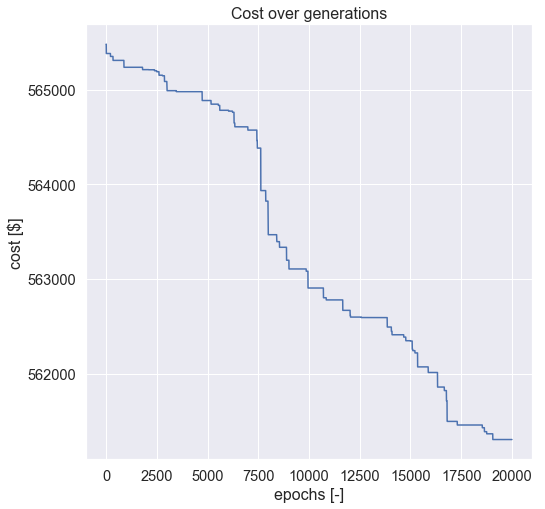

In [818]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(df_pop.loc[indice].values)

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

#### Save results

In [819]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_gen20000_s561303.pkl']

## Run with pop by days

### Evaluation #1

In [60]:
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

In [61]:
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS))

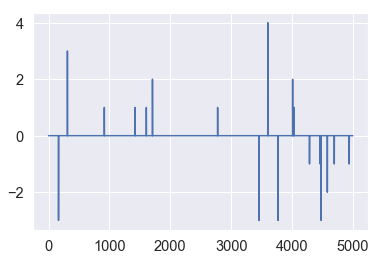

In [62]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [63]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
469  665206.371332
0    672254.027668
700  677348.768396
300  679410.167648
635  679441.505966
479  681538.723476

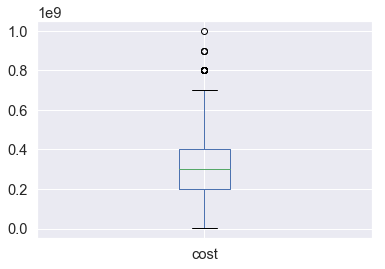

In [64]:
df_cost.boxplot()

###  Loop over generations

In [428]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_DAYS = 5
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

NameError: name 'cvpopo' is not defined

In [161]:
int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)

-2

In [ ]:
R_POP_LOST*df_cost_sort.shape[0]

#### Save results

In [74]:
# best score
#best_score = \
#cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + '/df_cost_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

In [124]:

#df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name,:].to_csv("test.csv")

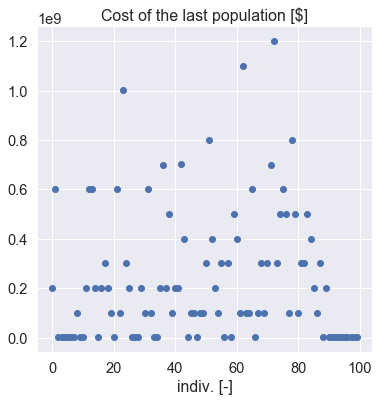

In [67]:
fig = plt.figure(figsize=(6, 6))
plt.title("Cost of the last population [$]")
plt.plot(df_cost["cost"], 'o')
ax = plt.gca()
ax.set_xlabel("indiv. [-]");
#ax.set_ylim([0 , 1e6])

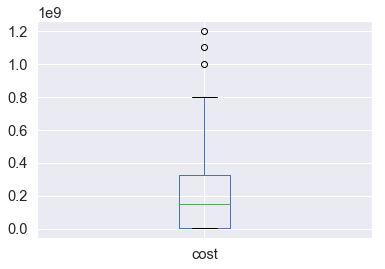

In [68]:
df_cost.boxplot()

In [72]:
cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

585102.5859791327

In [59]:
np.ceil(R_POP_LOST*df_cost_sort.shape[0])

10.0

In [60]:
nb_seeds

10

## Explore more

In [34]:
submission = pd.read_csv('submission_672254.0276683343.csv')
submission.head()

family_id  assigned_day
0          0            52
1          1            26
2          2           100
3          3             2
4          4            53

In [40]:
cost_function(submission['assigned_day'].tolist(), True)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [36]:
# function submission -> choice number
list_choice=[]
for fam_id in submission["family_id"]:
    assigned_day = submission.at[fam_id, "assigned_day"]
    list_choice.append(np.argmax((data.filter(items=['choice_{}'.\
                                 format(n) for n in range(0, 10)]).\
        loc[fam_id] == assigned_day).tolist()))

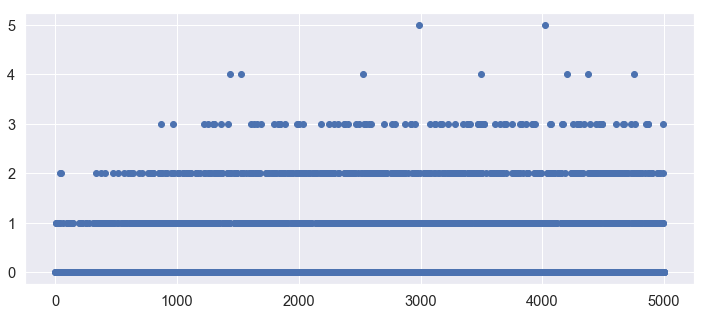

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(submission["family_id"], list_choice, 'o')

In [38]:
submission["choice"] = list_choice

In [39]:
submission["choice"].value_counts()

0    3535
1     946
2     416
3      94
4       7
5       2
Name: choice, dtype: int64